<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


# MIMIC-IV 

This is the notebook containing all the sql code we queried on Google BigQuery, the python code in particular for single-column-analysis, and the notes about the results we obtained. 

For the analysis of MIMIC-IV, we focus on the modules 'hosp' and 'icu'.
    
</div>

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [80]:
%run textColumn_analysis.ipynb

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
## Overview of the data

|  | feature name | Value |
| --- | ----------- | ----------- |
| Number of ICU stays (one patient can go through several ICUs)| `stay_id` | 94 458 |
| Number of distinct hospital admissions$^*$ | `hadm_id` | 85 242 |
| Number of distinct ICU patients | `subjet_id` | 65 366 |

$^*$one patient can be admitted several times into the hospital. Here we only include hospital admissions that are associated with an ICU stay.

</div>


<span style="color:silver">\# number of icu stays</span>
    
    SELECT COUNT(*) FROM physionet-data.mimiciv_3_1_icu.icustays ;

<span style="color:silver">\# number of distinct hospital admission associated with icu stays</span>
    
    SELECT COUNT(DISTINCT hadm_id) FROM `physionet-data.mimiciv_3_1_icu.icustays`

<span style="color:silver">\# number of distinct patients in ICU</span>
    
    SELECT COUNT(DISTINCT subject_id) FROM `physionet-data.mimiciv_3_1_icu.icustays`

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
The following query allows to count the number of ICU related hospital admissions per patient. In total, **11 743** patients were admitted several times to hospital and received intensive care. The number of admissions ranges from **1** to **36**, with an average of **1.30** stay per patient.
</div>


    SELECT subject_id, COUNT(*) AS count_stays FROM
      (SELECT subject_id, hadm_id, COUNT(*) FROM `physionet-data.mimiciv_3_1_icu.icustays`
        GROUP BY subject_id, hadm_id
        ORDER BY subject_id) AS patientsICUstays
    GROUP BY subject_id
    ORDER BY subject_id

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
During one hospital admission, a same patient can go through several intensive care units (ICUs). The following query account for the number of ICU units visited by patients during each of their stay.
</div>

    SELECT subject_id, hadm_id, COUNT(*) FROM `physionet-data.mimiciv_3_1_icu.icustays`
    GROUP BY subject_id, hadm_id
    ORDER BY subject_id

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

    - average length of stay in an ICU (not in hospital) is **3.63** fractional days, that is, 3 days and 15 hours
</div>

<span style="color:silver">\# temporary table with all patients that were in ICU</span>

    CREATE TEMPORARY TABLE ICUpatients AS (
      SELECT P.subject_id, P.gender, P.anchor_age, P.anchor_year, P.anchor_year_group, P.dod,
      S.hadm_id, S.stay_id, S.los
      FROM `physionet-data.mimiciv_3_1_icu.icustays` S
      JOIN `physionet-data.mimiciv_3_1_hosp.patients` P
      ON S.subject_id = P.subject_id
    ) ;

<span style="color:silver">\# average length of stay in an ICU </span>

    SELECT AVG(los) FROM ICUpatients

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

## Patients representation
We look at patients in ICU only. The following query allows to identify the patients and the id of their admission in hospital, when it as associated with an ICU stay. We saved the result of this query as a table named _patientICUstays_ in Google BigQuery.

By joining the other tables to study on _patientICUstays_, we were able to extract the data related to ICU stays only (without always joining these tables on the _icustays_ table) and perform our analysis from there.
</div>

    SELECT subject_id, hadm_id FROM `physionet-data.mimiciv_3_1_icu.icustays`
      GROUP BY subject_id, hadm_id
      ORDER BY subject_id

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**<center><u>We extract the ICU patient data from the _patients_ table (see following query) to study the profile of the patients in ICU).</u></center>**

**<u>Age</u>**

- age (`anchor_age`) of patients is always indicated, and ranges from **18** to **91** years old
- age average across distinct patients is **63.41**
- weighted average (_we count twice the age of a patient that was admitted twice into ICU_) is **63.00**

</div>

    SELECT *
    FROM (SELECT DISTINCT subject_id FROM `iame-int.ICU.patientICUstays`) S
    JOIN `physionet-data.mimiciv_3_1_hosp.patients` P
    ON S.subject_id = P.subject_id

<span style="color:silver">\# age average on distinct patients</span>

    SELECT AVG(anchor_age) 
    FROM `physionet-data.mimiciv_3_1_hosp.patients` P 
    JOIN (
        SELECT DISTINCT subject_id 
        FROM `physionet-data.mimiciv_3_1_icu.icustays`) S 
    ON P.subject_id=S.subject_id ;

<span style="color:silver">\# weighted age average of patients</span>

    SELECT AVG(P2.anchor_age)
    FROM `iame-int.ICU.patientICUstays` P
    JOIN `physionet-data.mimiciv_3_1_hosp.patients` P2
    ON P.subject_id = P2.subject_id

In [168]:
df_age_distinct = pd.read_csv("../Data/MIMIC-IV/patientsICUdata.csv")
age_distinct = df_age_distinct["anchor_age"]
print(np.median(age_distinct), np.quantile(age_distinct, 0.25), np.quantile(age_distinct, 0.75))
print(len(df_age_distinct))

65.0 53.0 76.0
65366


65.0 53.0 76.0
85242


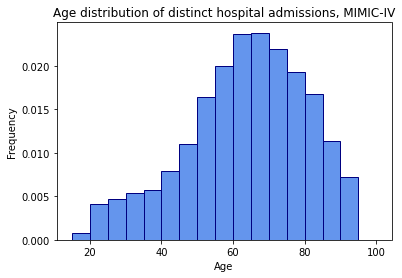

In [172]:
df_age_admissions = pd.read_csv("../Data/MIMIC-IV/admissions_age.csv")
age_admissions = df_age_admissions["anchor_age"]
print(np.median(age_admissions), np.quantile(age_admissions, 0.25), np.quantile(age_admissions, 0.75))
print(len(age_admissions))
bins = [5*k for k in range(3,21)]
age_admission_plot = plt.hist(age_admissions, bins=bins, edgecolor='navy', color='cornflowerblue', density=True)
plt.title("Age distribution of distinct hospital admissions, MIMIC-IV")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**<u>Gender</u>**

- `gender` of patients is always indicated
- percentage of women across distinct ICU patients is **43.82%**
- percentage of women across ICU stays (_a patient admitted twice to hospital with intensive care will count twice_) is **44.24%**

_Note that when we perform the computation accounting for the number of times patient is admitted to the hospital with intensive care, we don't perform the join directly on the_ icustays _table, because we don't want to take into account the several ICU in which the patient stays during one hospital admission_. 

- Using a <mark>validation query</mark>, we check that the number of distinct (`subject_id`, `gender`) tuples for ICU patients is equal to the number of distinct patients in ICU (65 366), and we conclude that there are no inconsistency among ICU patients' gender.
</div>

<span style="color:silver">\# percentage of women across distinct patients</span>

    SELECT gender, 100*COUNT(*)/(SELECT COUNT(DISTINCT subject_id) FROM `iame-int.ICU.patientICUstays`)
    FROM (SELECT DISTINCT subject_id FROM`iame-int.ICU.patientICUstays`) P
    JOIN `physionet-data.mimiciv_3_1_hosp.patients` P2
    ON P.subject_id = P2.subject_id
    GROUP BY gender

<span style="color:silver">\# percentage of women across hospital admission</span>

    SELECT gender, 100*COUNT(*)/(SELECT COUNT(*) FROM `iame-int.ICU.patientICUstays`)
    FROM `iame-int.ICU.patientICUstays` P
    JOIN `physionet-data.mimiciv_3_1_hosp.patients` P2
    ON P.subject_id = P2.subject_id
    GROUP BY gender

<span style="color:silver">\# validation query </span>

    SELECT DISTINCT P.subject_id, PP.gender
    FROM `iame-int.ICU.patientICUstays` P
    JOIN `physionet-data.mimiciv_3_1_hosp.patients` PP
    ON P.subject_id=PP.subject_id

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

We perform the following analysis across the 65 366 <u>distinct</u> ICU patients. The file _patientsICUdata.csv_ corresponds to the join of the _patientICUstays_ table with the _patients_ table, in order to obtain all ICU patient's data.

**`df_patients` is the csv file of all 65 366 ICU patients**.
</div>

In [3]:
df_patients = pd.read_csv("../Data/MIMIC-IV/patientsICUdata.csv")

# list of all patients age
L_age = df_patients["anchor_age"].tolist() 
# list of patient's genders
L_gender = df_patients["gender"].tolist()

# dataframe of female patients' age
F = df_patients[["anchor_age"]][df_patients["gender"] == "F"]
# dataframe of male patients' age
M = df_patients[["anchor_age"]][df_patients["gender"] == "M"]

print("Proportion of women among distinct patients is ", 100*len(F)/len(L_gender))
print("Minimum age in the database is ", min(L_age))
print("Maximum age in the database is ", max(L_age))

Proportion of women among distinct patients is  43.82400636416486
Minimum age in the database is  18
Maximum age in the database is  91


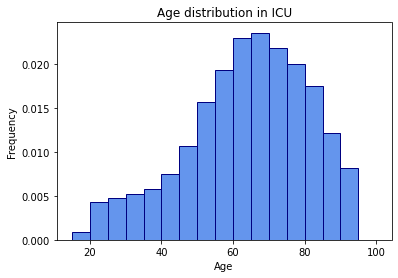

In [4]:
bins = [5*k for k in range(3,21)]
age_plot = plt.hist(L_age, bins=bins, edgecolor='navy', color='cornflowerblue', density=True)
plt.title("Age distribution in ICU")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

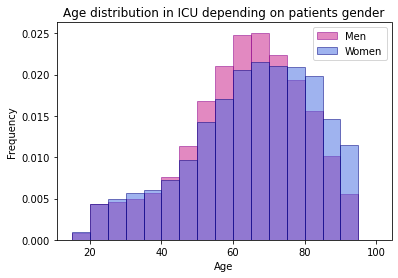

In [5]:
bins = np.linspace(15,100, 18)
plt.hist(M, bins=bins, label="Men", edgecolor='darkmagenta', color='mediumvioletred', alpha=0.5, density=True)
plt.hist(F, bins=bins, label="Women", edgecolor='navy', color='royalblue', alpha=0.5, density=True)
plt.legend()
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age distribution in ICU depending on patients gender")
plt.show()

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**<u>Race</u>**

Race in not available in the _patients_ table, but in the _admissions_ table.

All patients in ICU do have a race indicated (result of a LEFT JOIN query of _patientICUstays_ table with a table of non-null (`subject_id`, `race`) tuples on `subject_id` where the `race` IS NULL is empty) . However the count of distinct (`subject_id`, `race`) tuple is **66 330**, when there are  only 65 366 distinct patients in ICU. Indeed, **946** patients have several races indicated in their different hospital admissions:
- 1 with 5 races
- 15 with 3 races
- 930 with 2 races

So the collection of distinct (`subject_id`, `race`) is 66 330 but taking into account (by removing) the "extra" races: 66 330 - (5 + 3 × 15 + 2 × 930 - 946) = 65 336 which is indeed the distinct number of patients in the database.

<u>_Example:_</u> _patient_ 10036086 _is indicated 3 times as portuguese and 5 times as white (and insurace twice as "medicare" and 6 times "private", but insurance could change_)

To study the race representation among ICU patients, we remove all 946 patients for which the race is inconsistent.

**`df_patient_race` is the csv file of all (`subject_id`, `race`) tuples among ICU patients. `L_patient_severalRace` is the list of all `subject_id` that are registered with different races.**
</div>

In [173]:
# all races registered upon admission among ICU patients
df_patient_race = pd.read_csv("../Data/MIMIC-IV/patientsICUrace.csv")
print("The number of races registered is", len(df_patient_race))

# the list of patients (and their subject_id) who have different races indicated
L_patient_severalRace = pd.read_csv("../Data/MIMIC-IV/patientsSeveralRaces.csv")["subject_id"].tolist()
print("The number of patients with several races indicated is", len(L_patient_severalRace))

The number of races registered is 66330
The number of patients with several races indicated is 946


In [26]:
df_patient_race2 = df_patient_race[~ (df_patient_race["subject_id"].isin(L_patient_severalRace))]

# the count/representation of the different races in the database, excluding inconsistent patients
race_count = df_patient_race2["race"].value_counts()
race_count

race
WHITE                                        40100
UNKNOWN                                       7053
BLACK/AFRICAN AMERICAN                        4889
OTHER                                         2133
WHITE - OTHER EUROPEAN                        1589
UNABLE TO OBTAIN                              1587
ASIAN                                          773
ASIAN - CHINESE                                724
HISPANIC/LATINO - PUERTO RICAN                 722
WHITE - RUSSIAN                                549
HISPANIC/LATINO - DOMINICAN                    487
HISPANIC OR LATINO                             478
PATIENT DECLINED TO ANSWER                     413
BLACK/CAPE VERDEAN                             402
BLACK/CARIBBEAN ISLAND                         390
BLACK/AFRICAN                                  269
ASIAN - SOUTH EAST ASIAN                       229
PORTUGUESE                                     223
WHITE - EASTERN EUROPEAN                       183
ASIAN - ASIAN INDIAN      

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**<u>Death representation</u>**

- In the entire _admissions_ table, **11 790** rows (identified by `hadm_id`) have a `deathtime` indicated. This represents only **2.16%**
- Among the ICU related admissions only (listed in the _patientICUstays_ table), **9 466** admissions have `deathtime` indicated, which is **11.10%** of the ICU related hospital admissions. Moreover this implies that **80.29%** of the indicated `deathtime` relate to ICU admissions 
- **75 776** or **88.9%** of the hospital admissions have null deathtime
</div>

<span style="color:silver">\# number of hospital admissions that have a deathtime indicated</span>

    SELECT COUNT(*)
    FROM `physionet-data.mimiciv_3_1_hosp.admissions`
    WHERE deathtime IS NOT NULL

<span style="color:silver">\# number of ICU related hospital admissions that have a deathtime indicated</span>

    SELECT COUNT(*)
    FROM `physionet-data.mimiciv_3_1_hosp.admissions` A
    JOIN `iame-int.ICU.patientICUstays` P
    ON A.hadm_id=P.hadm_id
    WHERE deathtime IS NOT NULL

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

- Similarly in the entire _patients_ table, `dod` (date of death) is indicated in **38 301** rows, which represents **58.59%** of the patients.
- **43 424** or **66.43%** of the ICU patients have null `dod`
- Among the ICU patients, death is indicated with `dod` in the _patients_ table for **21 942** (or **33.57%**) of them. So **57.23%** of the indicated date of death relate to ICU patients.

</div>

<span style="color:silver">\# number of dod indicated among all patients</span>

    SELECT COUNT(*)
    FROM `physionet-data.mimiciv_3_1_hosp.patients`
    WHERE dod IS NOT NULL

<span style="color:silver">\# number of distinct ICU patients who have a date of death indicated</span>

    SELECT COUNT(*)
    FROM (SELECT DISTINCT subject_id FROM `iame-int.ICU.patientICUstays`) P
    JOIN `physionet-data.mimiciv_3_1_hosp.patients` PP
    ON P.subject_id=PP.subject_id
    WHERE dod IS NOT NULL

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

The following query returns a table with all (`subject_id`, `hadm_id`) pairs, the admission time (`admittime`), the `deathtime` indicated in the _admission_ table and the `dod` (date of death) in the _patients_ table. 

- **9 466** non-null `deathtime`
- **33 160** non-null `dod` (**!** *this is when looking at date of death across admissions, however note that `dod` relates to the patient*
- **9 449** or **11.08%** of the `discharge_location` are "DIED"
- `discharge_location` and `hadm_id` are always consistent (indeed 85 242 distinct pairs `hadm_id`-`discharge_location`)
- **842** null `discharge_location`
</div>

<span style="color:silver">\# death comparison - this function returns 85 242 rows </span>

    SELECT P.subject_id, P.hadm_id, A.admittime, PP.dod, A.deathtime, A.discharge_location
    FROM `iame-int.ICU.patientICUstays` P
    JOIN `physionet-data.mimiciv_3_1_hosp.patients` PP
    ON P.subject_id=PP.subject_id
    JOIN `physionet-data.mimiciv_3_1_hosp.admissions` A
    ON P.subject_id=A.subject_id AND P.hadm_id=A.hadm_id
    ORDER BY P.subject_id

<span style="color:silver">\# table is result from above query</span>

    SELECT *
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonf12176720f5941177b08296d8ba9dc1d89ebb0d35b4189eaa7f201192bd2e139`
    WHERE discharge_location = "DIED"
    AND deathtime IS NULL AND dod IS NULL

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

We compare all values to search for inconsistencies. 

- _deathtime_ and _dod_ are always consistent
- where _deathtime_ is indicated, then so is _dod_

However:
- 89 patients died in-hospital but their discharge location is different from "DIED"
- there are also 158 rows where discharge_location=DIED but deathtime is not indicated, and among those rows, 8 have both dod and deathtime null
</div>

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
## Diagnoses representation

We obtain the frequency of the different diagnosis among ICU patients.
</div>

<span style="color:silver">\# diagnoses of ICU patients</span>

    CREATE TEMPORARY TABLE patients AS 
        (SELECT P.subject_id, P.hadm_id, DD.long_title
        FROM `iame-int.ICU.patientICUstays` P
        JOIN `physionet-data.mimiciv_3_1_hosp.diagnoses_icd` D
        ON P.hadm_id=D.hadm_id AND P.subject_id=D.subject_id
        JOIN `physionet-data.mimiciv_3_1_hosp.d_icd_diagnoses` DD
        ON D.icd_code=DD.icd_code AND D.icd_version=DD.icd_version
        ORDER BY P.subject_id) ;

<span style="color:silver">\# first count (see further analysis) of number of diagnosis</span>

    SELECT COUNT(DISTINCT long_title) FROM patients ;
    
<span style="color:silver">\# frequencies of the different diagnosis</span>

    SELECT long_title, 100*COUNT(*)/65366 AS diagnose_freq
    FROM patients
    GROUP BY long_title

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
Among the ICU patients:
- a total of **1 524 373** results 
- we find **18 582** distinct (`icd_code`, `icd_version`) pairs (but see after for analysis on "distinct") 
- moreover **24** ICU patients (identified with a <mark>LEFT JOIN</mark>) don't have any diagnosis (missing `icd_code` ou `icd_version`)
- verification query: all (`icd_code`, `icd_version`) of ICU patients exist in *d_icd_diagnoses*
</div>

<span style="color:silver">\# because the above query is a big query (JOINs) with a lot of computations</span>

<span style="color:silver">\# we reduce the joins to only extract the ICD code and versions we are interested in</span>

<span style="color:silver">\# (by checking their frequency)</span>

<span style="color:silver">\# temporary table diagnoses table for ICU patients</span>

    CREATE TEMPORARY TABLE patients AS 
        (SELECT P.subject_id, P.hadm_id, D.icd_code, D.icd_version
        FROM `iame-int.ICU.patientICUstays` P
        JOIN `physionet-data.mimiciv_3_1_hosp.diagnoses_icd` D
        ON P.hadm_id=D.hadm_id AND P.subject_id=D.subject_id) ;

<span style="color:silver">\# frequency of each diagnosis among ICU patients</span>

    SELECT icd_code, icd_version, COUNT(*) AS co 
    FROM patients 
    GROUP BY icd_code, icd_version
    ORDER BY co DESC ;

<span style="color:silver">\# total number of ICU diagnosis</span>

    SELECT COUNT(*) FROM patients 

<span style="color:silver">\# ICU patients without any diagnosis</span>

    SELECT P.subject_id, P.hadm_id, D.icd_code, D.icd_version
        FROM `iame-int.ICU.patientICUstays` P
        LEFT JOIN `physionet-data.mimiciv_3_1_hosp.diagnoses_icd` D
        ON P.hadm_id=D.hadm_id AND P.subject_id=D.subject_id
        WHERE D.icd_code IS NULL OR D.icd_version IS NULL
    
<span style="color:silver">\# verification query on the icd codes and versions in patients</span>

    SELECT P.icd_code, P.icd_version
    FROM (SELECT DISTINCT icd_code, icd_version FROM `soy-surge-447815-u0._script775c138d311059a462a196d2eb09e1e7c2247354.patients`) P
    LEFT JOIN `physionet-data.mimiciv_3_1_hosp.d_icd_diagnoses` D
    ON P.icd_code=D.icd_code AND P.icd_version=D.icd_version
    WHERE D.icd_code IS NULL OR D.icd_version IS NULL

<span style="color:silver">\# obtaining diagnosis titles from their code and version</span>

    SELECT DISTINCT long_title
    FROM `iame-int.ICU.diagnosesICU` I
    JOIN `physionet-data.mimiciv_3_1_hosp.d_icd_diagnoses` D
    ON I.icd_code=D.icd_code AND I.icd_version=D.icd_version

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
From **1** to **39** diagnoses per hospital stay (`hadm_id`), with an average of **17.88** diagnosis per patient.
</div>

<span style="color:silver">\# number of diagnosis per hospital admission</span>

    SELECT P.subject_id, P.hadm_id, COUNT(*) as co 
        FROM `iame-int.ICU.patientICUstays` P
        LEFT JOIN `physionet-dat a.mimiciv_3_1_hosp.diagnoses_icd` D
        ON P.hadm_id=D.hadm_id AND P.subject_id=D.subject_id
        GROUP BY subject_id, hadm_id

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

## Data quality: available data, data consistency, table and single-column analysis 

**With a focus on laboratory measurements, drug dosage and pharmacology data**

### **<u>Schema and table relations</u>**
Here we analyse schemas, relations between tables (foreign keys), redundancy of information. We have the following candidate/primary keys, and unique column combinations.

<u>In _hosp_ module:</u>
- _admissions_ : `hadm_id` is a primary key
- _patients_  : `subject_id` is a primary key 
- _diagnoses_icd_ : no primary key, one patient can be diagnosed several diseases upon admission
- _emar_ : `emar_id` is a candidate key, (`subject_id`, `emar_seq`) as well
- _emar_detail_ : (`emar_id`, `parent_field_ordinal`), (`subject_id`, `emar_seq`, `parent_field_ordinal`) are candidate keys (similar to _emar_)
- _prescriptions_ : no primary keys (there are groups of attributes that uniquely identify rows, but that may be null). However no duplicate rows (grouped by a group of attributes and counted)
- _pharmacy_ : `pharmacy_id`
- _microbiologyevents_ : `microevent_id`

<u>In _ICU_ module</u>:
- _icustays_: `stay_id` is a primary key
- _inputevents_ : no candidate/primary keys (_except if we count the distinct values_)

### **<u>Table and single-column analysis</u>**

_For all analysis, unless specified otherwise, we extract the ICU related data. For example, we don't take into account in the list of distinct diagnosis an illness that was not registered for an ICU patient_. There are **85 242** stays in ICU (defined by a `subject_id`-`hadm_id` tuple, where one tuple may be associated with several `stay_id` in case the patient changed unit during his stay). Moreover, a lot of the analysis also imply <mark>JOIN</mark> queries to obtain human-understandable values (for example, the _diagnoses_icd_ table indicates the code for the diagnose, so we perform a join query on the table *d_icd_diagnoses* to obtain the actual name of the disease.

- null values
- consistency of units, strings, abbreviations etc
- outliers

**In the analysis that follows, we work table by table, checking relations between tables as we work on them**. 
</div>

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

### **<u>ICU stays</u>** - the _icustays_ table (_hosp_ module)

- there is redundancy in the table as all ICU stays have the same first care unit (`first_careunit`) and last care unit (`last_careunit`).

**`df_unitstays` is the csv file of all different intensive care units, the number of stays registered in the database of each of these units and the percentage it represents**.
</div>

<span style="color:silver">\# redundancy of first_careunit and last_careunit features</span>

    SELECT COUNT(*)
    FROM `physionet-data.mimiciv_3_1_icu.icustays` S
    WHERE S.first_careunit=S.last_careunit ;

<span style="color:silver">\# different ICU's and the percentage of stays they represent in MIMIC </span>

    SELECT S.first_careunit, COUNT(*) AS count_stays, 100*(COUNT(*)/(SELECT COUNT(*) FROM `physionet-data.mimiciv_3_1_icu.icustays`)) AS percentage_stays
    FROM `physionet-data.mimiciv_3_1_icu.icustays` S
    GROUP BY S.first_careunit
    ORDER BY count_stays DESC ;

In [39]:
df_unitstays = pd.read_csv("../Results/MIMIC-IV/count_unit_stays.csv")
df_unitstays

,first_careunit,count_stays,percentage_stays
0,Medical Intensive Care Unit (MICU),20703,21.917678
1,Medical/Surgical Intensive Care Unit (MICU/SICU),15449,16.355417
2,Cardiac Vascular Intensive Care Unit (CVICU),14771,15.637638
3,Surgical Intensive Care Unit (SICU),13009,13.772259
4,Coronary Care Unit (CCU),10775,11.407186
5,Trauma SICU (TSICU),10474,11.088526
6,Neuro Intermediate,5776,6.114887
7,Neuro Surgical Intensive Care Unit (Neuro SICU),1751,1.853734
8,Neuro Stepdown,1421,1.504372
9,Surgery/Vascular/Intermediate,145,0.153507


<span style="color:silver">\# distinct ICU patients</span>

    SELECT DISTINCT subject_id FROM `physionet-data.mimiciv_3_1_icu.icustays`

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

### **<u>Diagnoses</u>** - the _diagnoses_icd_ table  (_hosp_ module)

- at first, there are **17 557** different diagnoses among ICU patients

**`df_diagnoses` is the csv file of all illnesses and conditions that were diagnosed for ICU patients, and their frequency among ICU patients (in the _diagnose_icd_ table)**.
</div>

In [75]:
df_diagnoses = pd.read_csv("../Data/MIMIC-IV/diagnosesICUpatients.csv")

In [78]:
countCapitalization(df_diagnoses, "long_title")

{'initial_count': 17557,
 'decap_count': 17551,
 'diff_distinct_decap': 6,
 'list_df_diff_cap': ['Pneumonia due to other Gram-negative bacteria',
  'Pneumonia due to other gram-negative bacteria',
  'Budd-Chiari syndrome',
  'Malignant neoplasm of ampulla of vater',
  'Malignant neoplasm of ampulla of Vater',
  'Budd-chiari syndrome',
  'Pneumonia due to staphylococcus, unspecified',
  'Pneumonia due to streptococcus, group B',
  'Pneumonia due to Staphylococcus, unspecified',
  'Pneumonia due to mycoplasma pneumoniae',
  'Pneumonia due to Streptococcus, group B',
  'Pneumonia due to Mycoplasma pneumoniae']}

In [79]:
countExtraSpaces(df_diagnoses, "long_title")

{'initial_count': 17557,
 'nospace_count': 17556,
 'diff_distinct_nosp': 1,
 'list_df_diff_nosp': ['Obstructive sleep apnea (adult)(pediatric)',
  'Obstructive sleep apnea (adult) (pediatric)']}

In [120]:
diagnose_typos = detectTypos(df_diagnoses, "long_title")
diagnose_typos

,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,"pneumonia due to streptococcus, group b",pneumonia due to other streptococcus,80,86,91,0.138998
1,"pneumonia due to streptococcus, group b","pneumonia due to streptococcus, group a",97,97,97,0.064019
2,"pneumonia due to staphylococcus, unspecified","pneumonia due to streptococcus, unspecified",92,92,92,0.112422
3,malignant neoplasm of ampulla of vater,malignant neoplasm of parietal lobe,74,71,75,0.139717
4,malignant neoplasm of ampulla of vater,malignant neoplasm of tail of pancreas,79,71,75,0.125988
...,...,...,...,...,...,...
202493,displaced fracture of lateral end of left clav...,nondisplaced midcervical fracture of left femu...,73,70,73,0.105080
202494,neoplasm of uncertain behavior of right ovary,torsion of right ovary and ovarian pedicle,44,53,60,0.138435
202495,other specified malposition or malpresentation...,diabetes mellitus without mention of complicat...,44,57,61,0.130032
202496,"burn of unspecified degree of left thigh, init...","burn of unspecified degree of right thigh, ini...",94,91,95,0.079701


As it seems that for diagnose typo detection, the threshold were too high (202 498 potential typos) we extract from the database data with higher thresholds. By filtering, we reduce the detection to 5145 potential typos.

In [121]:
filtered_diagnose_typos = diagnose_typos[(diagnose_typos["simple_ratio"]==100) 
                                         | (diagnose_typos["token_set_ratio"]==100) 
                                         | (diagnose_typos["token_sort_ratio"]==100)][["s1", "s2"]]

for index, datapoint in filtered_diagnose_typos.iterrows() :
    print(index)
    print("s1 : ", datapoint["s1"])
    print("s2 : ", datapoint["s2"])

54
s1 :  other migraine, intractable, with status migrainosus
s2 :  other migraine, not intractable, with status migrainosus
143
s1 :  unspecified fracture of right femur, initial encounter for closed fracture
s2 :  unspecified fracture of head of right femur, initial encounter for closed fracture
295
s1 :  postprocedural seroma of a circulatory system organ or structure following other circulatory system procedure
s2 :  postprocedural hemorrhage, hematoma and seroma of a circulatory system organ or structure following other procedure
398
s1 :  acute appendicitis with generalized peritonitis, with abscess
s2 :  acute appendicitis with generalized peritonitis, without abscess
404
s1 :  unspecified peripheral retinal degeneration
s2 :  peripheral retinal degeneration, unspecified
415
s1 :  pneumonia, organism unspecified
s2 :  pneumonia, unspecified organism
424
s1 :  long-term (current) use of insulin
s2 :  long term (current) use of insulin
432
s1 :  hyperosmolality and hypernatremia
s

In [38]:
typos_indexes = [404,415,424,433,493,744,914,1065,2206,2391,2596,2637,2737,2803,3095,4167,4174,4290,4725,5265,5273,5277,
                5865,5933,5973,6741,6857,7437,7581,8767,8932,9255,9766,9890,9987,10401,12057,12082,12123,12323,13476,
                14240,14351,15216,15498,15675,15806,15874,15876,16430,18273,18510,18572,18592,21236,21246,21276,22649,
                24041,24461,26135,27664,27919,28693,29195,29225,29341,30195,30327,31896,31962,33193,35470,35827,
                36044,36941,41282,41294,41302,41652,42300,44281,45044,46433,46704,46707,48657,49665,49780,50723,50738,
                52187,52905,54213,55044,56322,56914,57494,57495,61038,61625,61831,62164,62172,64022,64932,64972,66678,
                66703,68692,68796,70704,71519,71600,73687,74509,74774,75484,77646,78589,80165,81853,82247,84483,86664,
                90168,91522,91959,97593,97875,98687,101922,102604,104915,107094,110071,111490,114733,119328,119365,
                120577,122540,123315,128385,132515,133845,134745,136738,139201,139314,145219,147033,147233,148514,152072,
                152188,152210,154716,156661,158235,159454,160232,161463,165658,172091,182621,183499,185349,192374,193225,
                195504,197265,201421,202497]

print("Number of typos detected in the distinct diagnoses of patient is", len(typos_indexes))

Number of typos detected in the distinct diagnoses of patient is 174


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
There are pairs of diagnoses that look like typo but present a subtlety and might be better detected by healthcare professionals, such as _pneumonia due to methicillin susceptible staphylococcus aureus_
and _methicillin susceptible pneumonia due to staphylococcus aureus_ (index $4174$, and $5273$ present the same subtlety).

To understand how the function works: it flaggs for example two similar sentences for which the only difference is "_cerebellar_ artery" versus "_cerebral_ artery" (index $5064$).

Another subtlety that might be better interpreted by healthcare professional is the interchangeably use of the terms "unspecified" and "other" in many sentences (not counted in the 174 mentionned above). For example: "_other place in unspecified non-institutional (private) residence as the place of occurrence of the external cause_" and "_unspecified place in other non-institutional residence as the place of occurrence of the external cause_".

There are also flagged sentences such as (index $18510$) "_unspecified erythematous condition_" and "_erythematous condition, unspecified_", which seems to present a difference in their meaning but it would be up to qualify individuals to confirm or not the equivalence in this case.

</div>

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
Because there are so many diagnosis, we can not verify them one by one for outliers. Thus, we perform outlier detection on the length of the feature. Some diagnosis are very long, but the values returned by the textStatistics function can be manually checked (actually, if outliers occur, it is more likely that they would be very short).

We don't detect any errors.
</div>

54.85424616961895 4 219


('Outliers:',
 ['Hypertensive heart and chronic kidney disease with heart failure and stage 1 through stage 4 chronic kidney disease, or unspecified chronic kidney disease',
  'Other surgical procedures as the cause of abnormal reaction of the patient, or of later complication, without mention of misadventure at the time of the procedure',
  'Other medical procedures as the cause of abnormal reaction of the patient, or of later complication, without mention of misadventure at the time of the procedure',
  'Other specified procedures as the cause of abnormal reaction of patient, or of later complication, without mention of misadventure at time of procedure',
  'Other specified surgical operations and procedures causing abnormal patient reaction, or later complication, without mention of misadventure at time of operation',
  'Surgical operation with anastomosis, bypass or graft as the cause of abnormal reaction of the patient, or of later complication, without mention of misadventure at 

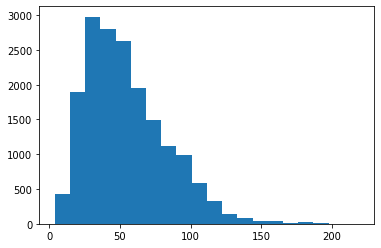

In [210]:
textStatistics(df_diagnoses, "long_title")

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
**Sepsis related diagnosis**

We then extract from the list of all diagnosis titles, the ones that include either "sepsis" or "Sepsis".
*We checked that, when taking all titles as lowcase letters, we get the same number (**36** of sepsis related diagnoses. this confirms that there is no "sEpsis" for example, or more generally no other capitalization.* We then obtained a list of all `long_title` sepsis diagnoses, and using the <mark>IN</mark> command in SQL, we extracted from *d_icd_diagnosis* all (`icd_code`, `icd_version`) associated with sepsis.

Note that we obtained **38** such pairs, proving that there are 2 diagnosis `long_title` that are referenced differently in the *d_icd_diagnoses* table. 

To be able to perform a join later on and identify the number of ICU patient with sepsis (of any kind), we saved the result of the SQl query (with `icd_code`, `icd_version`, `long_title`) as a BigQuery table. 

Among all ICU admissions (in hospital, `hadm_id`), we count **20 618** admissions in ICU (`subject_id`-`hadm_id` pair) with sepsis diagnosis.

The most frequent sepsis diagnosis are:
- "Severe sepsis with septic shock" with **5 374** cases among the hospital admisisons
- "Sepsis, unspecified organism" with **4 767** cases
- "Severe sepsis" with **4 443** cases
</div>

In [197]:
# now we obtain the sepsis diagnoses and their capitalization 
sepsis_diagnoses1 = df_diagnoses[df_diagnoses.long_title.str.contains("sepsis")]
sepsis_diagnoses2 = df_diagnoses[df_diagnoses.long_title.str.contains("Sepsis")]

sepsis_diagnoses = sepsis_diagnoses1["long_title"].tolist() + sepsis_diagnoses2["long_title"].tolist()

print("There are", len(sepsis_diagnoses), "sepsis related diagnoses")

There are 36 sepsis related diagnoses


<span style="color:silver">\# code and version related with sepsis diagnosis in ICU</span>

    SELECT icd_code, icd_version, long_title
    FROM `physionet-data.mimiciv_3_1_hosp.d_icd_diagnoses`
    WHERE long_title IN ('Severe sepsis with septic shock',
     'Severe sepsis',
     'Severe sepsis without septic shock',
     'Other specified sepsis',
     'Other Gram-negative sepsis',
     'Other streptococcal sepsis',
     'Gram-negative sepsis, unspecified',
     'Candidal sepsis',
     'Salmonella sepsis',
     'Puerperal sepsis',
     'Streptococcal sepsis, unspecified',
     'Puerperal sepsis, delivered, with mention of postpartum complication',
     'Puerperal sepsis, postpartum condition or complication',
     'Actinomycotic sepsis',
     'Listerial sepsis',
     'Gonococcal sepsis',
     'Sepsis, unspecified organism',
     'Sepsis',
     'Sepsis due to Escherichia coli [E. coli]',
     'Sepsis due to Methicillin susceptible Staphylococcus aureus',
     'Sepsis due to Enterococcus',
     'Sepsis due to Methicillin resistant Staphylococcus aureus',
     'Sepsis following a procedure, initial encounter',
     'Sepsis due to Pseudomonas',
     'Sepsis due to other specified staphylococcus',
     'Sepsis due to streptococcus, group B',
     'Sepsis due to anaerobes',
     'Sepsis due to Streptococcus pneumoniae',
     'Sepsis due to Serratia',
     'Sepsis due to streptococcus, group A',
     'Sepsis due to Hemophilus influenzae',
     'Sepsis due to unspecified staphylococcus',
     'Sepsis following an obstetrical procedure',
     'Sepsis following incomplete spontaneous abortion',
     'Sepsis following a procedure, subsequent encounter',
     'Sepsis following (induced) termination of pregnancy')

<span style="color:silver">\# ICU patients with sepsis diagnosis </span>

    SELECT * 
    FROM `iame-int.ICU.patientICUstays` P
    INNER JOIN `physionet-data.mimiciv_3_1_hosp.diagnoses_icd` D ON P.hadm_id=D.hadm_id AND P.subject_id=D.subject_id
    INNER JOIN `iame-int.ICU.sepsisDiagnoses` S ON D.icd_code=S.icd_code AND D.icd_version=S.icd_version 

In [202]:
df_sepsis_diagnoses = pd.read_csv("../Data/MIMIC-IV/sepsis_diagnoses.csv")
df_sepsis_diagnoses

,long_title,f0_,sepsis_diagnose
0,Severe sepsis,4443,21.549132
1,Sepsis,1404,6.809584
2,Severe sepsis without septic shock,799,3.875255
3,Other specified sepsis,793,3.846154
4,"Sepsis, unspecified organism",4767,23.120574
5,Sepsis due to Methicillin susceptible Staphylo...,374,1.813949
6,Sepsis due to Enterococcus,326,1.581143
7,Other Gram-negative sepsis,314,1.522941
8,Candidal sepsis,107,0.518964
9,Sepsis due to Pseudomonas,144,0.698419


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
**<u>Time and delays</u>**

Because time and delays of administration of medication can be crucial for the patient survival, in particular in the case of sepsis, we check whether it is available:

<u>Diagnosis:</u> Time of diagnosis is not indicated

<u>Medication</u>
- `charttime` in _emar_ (ICU related only) is a NON-NULL timestamp
- `scheduletime` in _emar_ (ICU related only) is null for **2 681** or less than **0.02%**
- `starttime` in _pharmacy_ (ICU related only) is null for **11 711** or **0.18%** of the rows (and exactly the same number in _prescriptions_, by equality of fields, it however represents **0.14%** in _prescriptions_)
- `stoptime` in _pharmacy_ (ICU related only) is null for **48 946** or **0.7%** of the rows (**19349*8 or **0.02%** in _prescriptions_)
- `starttime` and `endtime` in _inputevents_ are never null

*note that for `stoptime`, the number of null rows in _prescriptions_ and _pharmacy_ differs, whereas it did not when joining both tables. This is because there are pharmacies that don't have any prescriptions* 
</div>

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
### **<u>Microbiology data</u>**: the _microbiologyevents_ table  (_hosp_ module)

1) _The first query returns the list of all the ICU patient stays and the associated microbiology events. If a patient does not have such event, then the tuple (`subject_id`, `hadm_id`) will only appear once with `microevent_id`=NULL (because of left join)_

2) **17 865** ICU patients, or **27.33%** of them, don't have any microbiology data.

3) From this, <u>for patients who do have associated micro data</u>, we can compute the number of `microevent_id` (row in _microbiologyevents_ table) per patient. It ranges from **1** to **514**, with an average of **12.45** microbiology measurements (rows in _microbiologyevents_ table) per patient admission ((`subject_id`, `hadm_id`) pair).

4) For patients who <u>do have microbiology data associated</u>, we compute the number of micro-tests performed for each specimen (from MIMIC documentation: _specimen from which the microbiology measurement was made. Most microbiology measurements are made on patient derived samples (specimens) such as blood, urine, and so on. Often multiple measurements are made on the same sample, and the `micro_specimen_id` will group measurements made on the same sample, e.g. organisms which grew from the same blood sample_). From this we obtain that the average number of tests per patient's specimen is **1.99**, ranging between **1** and **54**.
</div>

<span style="color:silver">\# query 1)</span>

    SELECT I.subject_id, I.hadm_id, M.microevent_id 
    FROM `iame-int.ICU.patientICUstays` I 
    LEFT JOIN `physionet-data.mimiciv_3_1_hosp.microbiologyevents` M
    ON I.subject_id=M.subject_id AND I.hadm_id=M.hadm_id ;

<span style="color:silver">\# query 2)</span>

<span style="color:silver">\# from query 1) </span>

<span style="color:silver">\# note that here we write a nested query but in reality, we query from the above result table</span>

    SELECT COUNT(*) 
    FROM (
        SELECT I.subject_id, I.hadm_id, M.microevent_id 
        FROM `iame-int.ICU.patientICUstays` I 
        LEFT JOIN `physionet-data.mimiciv_3_1_hosp.microbiologyevents` M
        ON I.subject_id=M.subject_id AND I.hadm_id=M.hadm_id ;)
    WHERE microevent_id IS NULL 

<span style="color:silver">\# query 3)</span>

<span style="color:silver">\# here again, nested query but we actually simply query result from query 1</span>

    SELECT subject_id, hadm_id, COUNT(*) AS count_micro
    FROM (
        SELECT I.subject_id, I.hadm_id, M.microevent_id 
        FROM `iame-int.ICU.patientICUstays` I 
        LEFT JOIN `physionet-data.mimiciv_3_1_hosp.microbiologyevents` M
        ON I.subject_id=M.subject_id AND I.hadm_id=M.hadm_id ;)
    WHERE microevent_id IS NULL 
    GROUP BY subject_id, hadm_id
    ORDER BY count_micro DESC

<span style="color:silver">\# query 4)</span>

    CREATE TEMPORARY TABLE microeventsICU AS (
      SELECT I.subject_id, I.hadm_id, M.microevent_id, M.micro_specimen_id
      FROM `iame-int.ICU.patientICUstays` I 
        JOIN `physionet-data.mimiciv_3_1_hosp.microbiologyevents` M
      ON I.subject_id=M.subject_id AND I.hadm_id=M.hadm_id 
    ) ;
    SELECT subject_id, hadm_id, micro_specimen_id, COUNT(*) AS test_count
    FROM microeventsICU 
    GROUP BY subject_id, hadm_id, micro_specimen_id ;

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
**For the rest of the microbiology analysis for ICU patients, we extract the ICU related data and save the result as a new BigQuery table named _microbiologyeventsICU_.**

_The constraint on having a unique microevent_id identifier for each row is respected (see <mark>validation query</mark>_).
</div>

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
Among all the **856 452** (ICU related) microbiology events, **313 195** are associated with the detection of an organism.
</div>

<span style="color:silver">\# validation query for microevent_id being a unique identifier</span>

    SELECT microevent_id, COUNT(*) AS count_microID
    FROM  `iame-int.ICU.microbiologyeventsICU`
    GROUP BY microevent_id
    HAVING count_microID > 1

<span style="color:silver">\# number of rows that detect an organism</span>

    SELECT * FROM `iame-int.ICU.microbiologyeventsICU` 
    WHERE org_itemid IS NOT NULL

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
**<u>Overview</u>** of the _microbiologyeventsICU_ table

- **856 452** rows
- **6** possible interpretations
- **595 924** null interpretations
- **4** possible values for quantities + NULL
- **838 544** null quantities → most of _quantity_ fields are empty (only **43** or less than **0.01%** rows have the value)

The `quantity` field has 5 possible values:
	
- null	
- MODERATE	
- SPARSE GROWTH	
- 10,000-100,000 CFU/mL	
- strictly bigger than 100,000 CFU/mL
</div>

<span style="color:silver">\# distinct values for quantity feature</span>

    SELECT DISTINCT quantity FROM `iame-int.ICU.microbiologyeventsICU`

<span style="color:silver">\# different counts for number of ICU microbiology events, interpretation, null interpretation, quantity, null quantity</span>

    SELECT COUNT(*), COUNT(DISTINCT interpretation) AS unique_interpretation, 
      (SELECT COUNT(*)  FROM `iame-int.ICU.microbiologyeventsICU` WHERE interpretation IS NULL) AS null_interpretation,
      COUNT(DISTINCT quantity) AS unique_quantity,
      (SELECT COUNT(*) FROM `iame-int.ICU.microbiologyeventsICU` WHERE quantity IS NULL) AS null_quantity
    FROM  `iame-int.ICU.microbiologyeventsICU`

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
**<u>Null values</u>** in _microbiologyeventsICU_

**In the _microbiologyeventsICU table_, there is an important number (**17865) of fully empty rows** (_there is an `microevent_id` but not any other data_). This represents **2.09%** of the table.


**200 785** rows (microbiology events) don't have any comments. Moreover looking closely at the comments, some of them can be considered to indicate the row as "null" for a study that would require the test to detect an organism:
- ___ (**67783** such rows; they indicate that the content has been fully de-identified)
- NO GROWTH.
- No significant growth.
- No growth to date.

Other comments specifically indicate the absence of growth observed, such as:
- NO MYCOBACTERIA ISOLATED.  
- NO LEGIONELLA ISOLATED.

Finally, several tests have indications that they were cancelled, but are still recorded in the microbiologyevents table. They will thus not provide any information to reasearch on such tests, unless related with administration or cancellation of such events. Comments provide information such as:
- TEST CANCELLED, PATIENT CREDITED.
- TEST NOT PERFORMED. 

### **TO DO**
identify how many rows are actually affected by those cases
</div>

<span style="color:silver">\# 1) </span>

    SELECT COUNT(*) FROM `iame-int.ICU.microbiologyeventsICU` WHERE comments IS NULL

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
**<u>Redundancy of columns</u>** in _microbiologyeventsICU_

- `dilution_text`, `dilution_value`, `dilution_comparison`: `dilution_text` is a concatenation of the two others OR `dilution_text` is only the formatted version of `dilution_value`, so there are three columns but only one gives the necessary information (to some extent, 2 if it is required to have the value as a float and the comparison as a string. But such processing can be done by the researcher). 

As the number of rows in _microbiologyeventsICU_ is huge, we are not able to export all the data from Google BigQuery. We check the aforementioned issue on a sample of **30 794** rows among the **250 439** rows that do have dilution variables, and find that it is valid for 100% of the sample.

**`df_sample_dilu` is the csv file containing the sample of 30 794 rows corresponding to microbiology events that do have dilution variables**.
</div>

In [40]:
df_sample_dilu = pd.read_csv('../Data/MIMIC-IV/microICU_nonemptydilution.csv')
print(df.columns)

Index(['microevent_id', 'subject_id', 'hadm_id', 'micro_specimen_id',
       'order_provider_id', 'chartdate', 'charttime', 'spec_itemid',
       'spec_type_desc', 'test_seq', 'storedate', 'storetime', 'test_itemid',
       'test_name', 'org_itemid', 'org_name', 'isolate_num', 'quantity',
       'ab_itemid', 'ab_name', 'dilution_text', 'dilution_comparison',
       'dilution_value', 'interpretation', 'comments'],
      dtype='object')


In [41]:
n_e = 0
index = 0
dilution_data = df[['dilution_text', 'dilution_comparison', 'dilution_value']]


for index, datapoint in dilution_data.iterrows() :
    index += 1
        
    dilution_text = datapoint['dilution_text']
    dilution_comparison = datapoint['dilution_comparison']
    dilution_value = datapoint['dilution_value']
    
    dilution_value_str = "{:g}".format(dilution_value)

    if dilution_text == dilution_comparison.strip() + dilution_value_str or dilution_text == dilution_value_str:
        n_e += 1
        
print("The percentage of this sample that satisfied the explained characteristic is " + str(100* n_e/len(dilution_data)) + "%" )

The percentage of this sample that satisfied the explained characteristic is 100.0%


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
**<u>Medical sense and value consistency</u>** in _microbiologyeventsICU_ table

For `interpretation` field, the MIMIC guide indicates that the letters 'S', 'R', 'I', 'P' stand for sensitive, resistant, intermediate, pending. This corresponds to the typical MIC qualitative categories for interpretation of results. However, **123** rows have the letters 'D', 'Z', 'N'
</div>

    SELECT * FROM `iame-int.ICU.microbiologyeventsICU` 
    WHERE interpretation != "R"
    AND interpretation != "I"
    AND interpretation != "S"
    AND interpretation != "P"

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**`intepretation`** is very often left empty (even when selecting the tests that are actually performed): **595,924** out of the **856,452** rows.
</div>

    SELECT * FROM `iame-int.ICU.microbiologyeventsICU` where interpretation IS NULL

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**`test_name`**

All abbreviation used for the test names are correct. There are no capitalizations nor spaces inconsistencies, and we don't detect any typos.

**`df_testnames` is the csv file of all distinct `test_name` in _microbiologyeventsICU_**.
</div>

In [174]:
df_testnames = pd.read_csv('../Data/MIMIC-IV/micro_distinct_testname.csv')
print("The number of values for test_name in the micro table is " + str(len(df_testnames)))

The number of values for test_name in the micro table is 142


In [175]:
detectTypos(df_testnames, "test_name")

,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,hbv viral load,hcv viral load,93,93,93,0.150756
1,epstein-barr virus vca-igg ab,epstein-barr virus vca-igm ab,97,97,97,0.088391
2,cmv igm antibody,cmv igg antibody,94,94,94,0.150756
3,direct influenza a antigen test,direct influenza b antigen test,97,94,97,0.074958
4,hcv viral load,cmv viral load,93,93,93,0.150756
5,r/o beta strep group a,r/o group b beta strep,64,95,95,0.100000
6,toxoplasma igg antibody,toxoplasma igm antibody,96,96,96,0.107833
7,molecular cytogenetics-dna probe,molecular cytogenetics - dna probe,97,100,100,0.116343
8,aerobic bottle gram stain,anaerobic bottle gram stain,96,96,96,0.092934


25.007042253521128 6 66


('Outliers:',
 ['immunofluorescent test for pneumocystis jirovecii (carinii)',
  'cytomegalovirus early antigen test (shell vial method)',
  'chlamydia trachomatis, nucleic acid probe, with amplification',
  'neisseria gonorrhoeae (gc), nucleic acid probe, with amplification',
  'direct antigen test for herpes simplex virus types 1 & 2'])

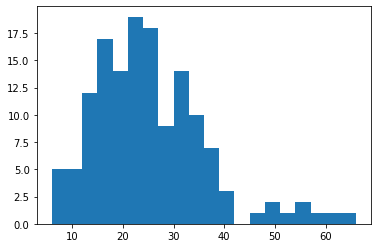

In [211]:
textStatistics(df_testnames, "test_name")

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**`culture_site`** has only one inconsistency, in letter capitalization ("SWAB" and "Swab")

**`df_culture_site` is the csv file of all distinct culture sites**.
</div>

In [69]:
df_culture_site = pd.read_csv("../Data/MIMIC-IV/microbiologyICU_culturesite.csv")
print(df_culture_site)

               spec_type_desc       f0_
0                        SWAB  0.817055
1                       STOOL  0.910205
2                 Blood (EBV)  0.074494
3                  IMMUNOLOGY  0.048844
4      BRONCHOALVEOLAR LAVAGE  0.945960
..                        ...       ...
77                FLUID WOUND  0.001429
78            CATHETER TIP-IV  0.200265
79               FOOT CULTURE  0.005566
80  URINE,SUPRAPUBIC ASPIRATE  0.000853
81    URINE,PROSTATIC MASSAGE  0.000025

[82 rows x 2 columns]


In [50]:
countCapitalization(df_culture_site, "spec_type_desc")
countExtraSpaces(df_culture_site, "spec_type_desc")
detectTypos(df_culture_site, "spec_type_desc")

,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance


17.358024691358025 3 56


('Outliers:',
 ['DIRECT ANTIGEN TEST FOR VARICELLA-ZOSTER VIRUS',
  'Direct Antigen Test for Herpes Simplex Virus Types 1 & 2'])

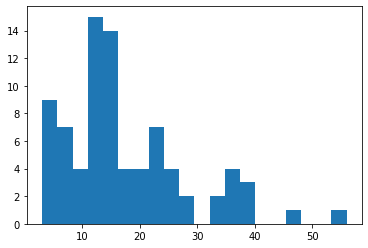

In [237]:
textStatistics(df_culture_site.dropna(), "spec_type_desc")

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

### **<u>Lab events:</u>** the _labevents_ table  (_hosp_ module)

1) We first create a <mark>temporary table</mark> to obtain, for all patients in ICU, their `subject_id`, `hadm_id`, the `specimen_id`, the `label` for the laboratory concept, the `fluid` (the substance on which the measurement is made), and the `category` (type of measurement) of the test. In total, the data contains measurements for **4 282 501** differement fluid samples. 

2) With a similar query and a <mark>left join</mark> we compute that the number of ICU patients with no laboratory data is **773** or only **0.01%** of the ICU patients admissions (`hadm_id`) (so **84 469** or **99.09%** do have lab data)

- number of rows in `labevents` data (filtered on ICU patients and admissions only, for admissions that do have associated lab data) ranges from **1** to **21 655** with an average of **459.49** rows per patient.
</div>

<span style="color:silver">\# query 1)</span>

    CREATE TEMPORARY TABLE labeventsICU AS (
      SELECT I.subject_id, I.hadm_id, L.specimen_id, D.label, D.fluid, D.category
      FROM `iame-int.ICU.patientICUstays` I 
      JOIN `physionet-data.mimiciv_3_1_hosp.labevents` L
      ON I.subject_id=L.subject_id AND I.hadm_id=L.hadm_id 
      JOIN `physionet-data.mimiciv_3_1_hosp.d_labitems` D ON D.itemid=L.itemid
      ORDER BY subject_id
    ) ;

<span style="color:silver">\# hospital admissions (hadm_id) that don't have any lab data</span>

    SELECT *
    FROM (
        SELECT I.subject_id, I.hadm_id, L.specimen_id, D.label, D.fluid, D.category
      FROM `iame-int.ICU.patientICUstays` I 
      JOIN `physionet-data.mimiciv_3_1_hosp.labevents` L
      ON I.subject_id=L.subject_id AND I.hadm_id=L.hadm_id 
      JOIN `physionet-data.mimiciv_3_1_hosp.d_labitems` D ON D.itemid=L.itemid
    ) A RIGHT JOIN `iame-int.ICU.patientICUstays` L
    ON A.subject_id=L.subject_id AND A.hadm_id=L.hadm_id
    WHERE A.hadm_id IS NULL 

<span style="color:silver">\# count of lab rows per hadm_id</span>

    SELECT hadm_id, COUNT(*)
    FROM (
        SELECT I.subject_id, I.hadm_id, L.specimen_id, D.label, D.fluid, D.category
      FROM `iame-int.ICU.patientICUstays` I 
      JOIN `physionet-data.mimiciv_3_1_hosp.labevents` L
      ON I.subject_id=L.subject_id AND I.hadm_id=L.hadm_id 
      JOIN `physionet-data.mimiciv_3_1_hosp.d_labitems` D ON D.itemid=L.itemid
    ) 
    GROUP BY hadm_id 

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

### **<u>Electronic Medicine Administration Record (eMAR)</u>**

**As indicated in the MIMIC guidelines, the eMAR system was only implemented over 2011-2013, thus the data is not available for all patients.**

- _emar_ : to record administration of a given medicine to an individual patient
- _emar_detail_ : information for each medicine administration made in the EMAR table
- _pharmacy_ : provides detailed information regarding filled medications which were prescribed to the patient
- _prescriptions_ : provides information about prescribed medications
</div>

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

_Now we extract from the four above tables the data associated with the ICU stays (`subject_id`-`hadm_id` tuples)_.

- 1) emar data from ICU patients. _the result set will include all rows from the tables that satisfy the join condition. If there are multiple rows in table E (physionet-data.mimiciv_3_1_hosp.emar) that have the same (`subject_id`, `hadm_id`) combination and this combination matches a row in table P (iame-int.ICU.patientICUstays), all those rows from table E will appear in the result set._ This is an extremely big table (**17 180 721** rows) and for the purpose of computations, we first extract 50,000 rows only. **As it is a huge table, for the purpose of checking we extract a sample of 50 000 rows of emar ICU data, that we save as a BigQuery table named _emarICUsubset_**.

Based on this subset, we extract the corresponding rows from the other tables. _Note that this does not include the foreign keys leading "nowhere" since we are performing a join_. **Moreover, because we perform the join on _emarICUsubset_, the following queries also return only a subset of the ICU related data**.

2) subset of emar_detail (**96,594** rows): _emar_detailICUsubset_

3) subset of pharmacy (**37 941**rows): _pharmacyICUsubset_

4) subset of prescriptions (**44 288** rows): _prescriptionsICUsubset_

## **TO DO** 
Finish checking the foreign keys 
</div>

<span style="color:silver">\# query 1) </span>

    SELECT E.* 
    FROM `physionet-data.mimiciv_3_1_hosp.emar` E
    JOIN `iame-int.ICU.patientICUstays` P
    ON P.subject_id=E.subject_id AND P.hadm_id=E.hadm_id

<span style="color:silver">\# query 2)</span>

    SELECT ED.* FROM `iame-int.ICU.emarICUsubset` E
    JOIN `physionet-data.mimiciv_3_1_hosp.emar_detail` ED
    ON E.emar_id=ED.emar_id

<span style="color:silver">\# query 3)</span>

    SELECT P.* FROM `iame-int.ICU.emarICUsubset` E
    JOIN `physionet-data.mimiciv_3_1_hosp.pharmacy` P
    ON E.pharmacy_id=P.pharmacy_id

<span style="color:silver">\# query 4)</span> 

    SELECT P.* FROM `iame-int.ICU.emarICUsubset` E
    JOIN `physionet-data.mimiciv_3_1_hosp.prescriptions` P
    ON E.pharmacy_id=P.pharmacy_id

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**<u>Overview</u>** (on relation between the four tables)


1) ICU patients stays that don't have any associated emar data: there are **34 696** rows in the result table (_identified with right join_) so quite a lot: **53.1%** of ICU patients don't have emar data.

2) <u>Based on sample data</u>, all the rows in _emar_ are associated with an `emar_id`, and all `emar_id` in _emar_ are valid (they actually lead to a row in _emar_detail_) 

3) Similarly all rows in _emar_detail_ lead to a row in _emar_ based on `emar_id`
</div>

<span style="color:silver">\# 1) query to identify ICU patient admissions that don't have any eMAR data</span>

    SELECT P.subject_id, P.hadm_id, E.emar_id
    FROM `physionet-data.mimiciv_3_1_hosp.emar` E
    RIGHT JOIN `iame-int.ICU.patientICUstays` P
    ON E.subject_id=P.subject_id
    AND E.hadm_id=P.hadm_id 
    WHERE E.emar_id IS NULL 

<span style="color:silver">\# 2) emar_id in emar</span>

    SELECT COUNT(*) FROM `iame-int.ICU.emarICUsubset`
    WHERE emar_id IS NULL

<span style="color:silver">\# validation queries for link emar → emar_detail on emar_id</span>

    SELECT * FROM `iame-int.ICU.emarICUsubset` E
    LEFT JOIN `physionet-data.mimiciv_3_1_hosp.emar_detail` ED
    ON E.emar_id=ED.emar_id
    AND E.subject_id=ED.subject_id

<span style="color:silver">\# result from above query</span>

    SELECT COUNT(*) FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon7ec88dc37309ae5050bb48dfa9de80e6598cf80c3a72bc6fee7164a118500414`
    WHERE emar_id_1 IS NULL

<span style="color:silver">\# 3) validation queries for link emar_detail → emar on emar_id</span>

    SELECT E.emar_id, ED.emar_id FROM `physionet-data.mimiciv_3_1_hosp.emar` E
    RIGHT JOIN `physionet-data.mimiciv_3_1_hosp.emar_detail` ED
    ON E.emar_id=ED.emar_id

<span style="color:silver">\# resutl from above query</span>

    SELECT COUNT(*) FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anonb0e8f58c9cfca1026baea4086c3cd9f541baf48a4ac927439462c7c24665d32b`
    WHERE emar_id IS NULL

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

1) In _emarICUsubset_, **12042** rows in emar don't have any associated pharmacy

2) In _emarICUsubset_ (**among the subset of ICU patients only**), there are **17** pharmacy references (pharmacy_id) that lead nowhere. The list of such pharmacies is listed in a saved file (_emar_wrongpharmacyid_). The last query checks this fact based on the saved list.

3) Following the discovery in 2), we check on the whole data set (including non ICU emar information). There are **727 392** pharmacy references in _emar_ that don't have a matching pharmacy in the table _pharmacy_. (the left join of emar on pharmacy gave **34 493 895** rows). We check with an inner join (last query in 3) ) and we indeed get "no data to display"

4) we check the same for _emar_detail_ table and we find **910 580** non-matching rows. **NOTE that this is a number of rows and not a number of distinct pharmacy ids**

5) note that there are **17 847 567** distinct pharmacy ids in _pharmacy_ table

There are **210 897** distinct erroneous `pharmacy_id` in _emar_, and **212 610** in _emar_detail_. Among this, they have **210 893** erroneous `pharmacy_id` in common and there is a total of **212 614** wrong `pharmacy_id`. _The list of these wrong `pharmacy_id` can be obtained from above queries_.
</div>

<span style="color:silver">\#1) emar rows that don't have a pharmacy_id</span>

    SELECT COUNT(*) FROM `iame-int.ICU.emarICUsubset`
    WHERE pharmacy_id IS NULL

<span style="color:silver">\# 2) rows in emarICUsubset with a pharmacy_id and the corresponding data from pharmacy</span>

    SELECT * FROM `iame-int.ICU.emarICUsubset` E
    LEFT JOIN `physionet-data.mimiciv_3_1_hosp.pharmacy` P
    ON E.pharmacy_id=P.pharmacy_id
    WHERE E.pharmacy_id IS NOT NULL

<span style="color:silver">\# from result of previous query, number of pharmacy referenced in emarICUsubuset but not in pharmacy</span>

    SELECT COUNT(*) FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon06ee8a38eca098809f7d754f3df6d6c3e359cc4d7a6a50d94b9e4d274fa45379`
    WHERE pharmacy_id_1 IS NULL

    SELECT * FROM `physionet-data.mimiciv_3_1_hosp.pharmacy` P
    JOIN `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon3e47e990bee7b688cca0695e14422371ca7e260183ffd10f4210ca282e322a89` WP
    ON WP.pharmacy_id=P.pharmacy_id

<span style="color:silver">\# 3) join of emar pharmacy_id (when non-null) with pharmacy table</span>

    SELECT E.pharmacy_id, P.pharmacy_id
    FROM `physionet-data.mimiciv_3_1_hosp.emar` E 
    LEFT JOIN `physionet-data.mimiciv_3_1_hosp.pharmacy` P
    ON E.pharmacy_id=P.pharmacy_id
    WHERE E.pharmacy_id IS NOT NULL

<span style="color:silver">\# with result from above query, count of pharmacy_id referenced in emar but non-existant in pharmacy</span>

    SELECT *
    FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon84dad9c68bb441ad079fc1752509f112400e420f5e42533b2eba044751d9428c`
    WHERE pharmacy_id_1 IS NULL 

<span style="color:silver">\# with result from above query, validation query that those pharmacies indeed don't exist in pharmacy table</span>

<span style="color:silver">\# result from query is empty</span>

    SELECT * FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon2018b5710b8ed11cec509fcaf6674d17854125cd27003f9b88be29b31a35442d` WP
    JOIN `physionet-data.mimiciv_3_1_hosp.pharmacy` P
    ON WP.pharmacy_id = P.pharmacy_id

<span style="color:silver">\# 4) join of emar_detail to pharmacy on pharmacy_id (when non-null)</span>

    SELECT E.pharmacy_id, P.pharmacy_id
    FROM `physionet-data.mimiciv_3_1_hosp.emar_detail` E 
    LEFT JOIN `physionet-data.mimiciv_3_1_hosp.pharmacy` P
    ON E.pharmacy_id=P.pharmacy_id
    WHERE E.pharmacy_id IS NOT NULL

<span style="color:silver">\# with result from above query, count of non-existing pharmacies</span>

    SELECT COUNT(*)
    FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon73b1cb194b0e0fb85e3f52e3513d7f2d80ecc038a1a3b85f6b147f23698c958a`
    WHERE pharmacy_id_1 IS NULL 

<span style="color:silver">\# 5) number of distinct pharmacy id's in pharmacy table</span>

    SELECT COUNT(DISTINCT pharmacy_id) FROM `physionet-data.mimiciv_3_1_hosp.pharmacy`

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

Note that the _emar_ table is also linked to the _prescription_ table through `pharmacy_id`.

1) **897 907** rows (not distinct) in _emar_detail_ have a `pharmacy_id` but are not linked to a row in _prescriptions_ (but the `pharmacy_id` could also point to a row in the pharmacy table!)

2) among the **distinct** pharmacies that are not associated with prescriptions info, we find that **241 318** of those `pharmacy_id` that are don't have associated data in the _prescriptions_ table, don't either **210 897** in the _pharmacy_ table.
</div>

<span style="color:silver">\# 1) join of emar and pharmacy on pharmacy_id</span>

    SELECT E.pharmacy_id, P.pharmacy_id
    FROM `physionet-data.mimiciv_3_1_hosp.emar` E
    LEFT JOIN `physionet-data.mimiciv_3_1_hosp.prescriptions` P
    ON E.pharmacy_id = P.pharmacy_id
    AND E.subject_id = P.subject_id
    AND E.hadm_id = P.hadm_id 
    WHERE E.pharmacy_id IS NOT NULL

<span style="color:silver">\# with result from above query, count of the number of rows in emar that don't have data in prescriptions</span>

    SELECT COUNT(*)
    FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon54687415cdbb70e4e0823f1f6892e4186fb483e869f98425189fc2216d330119`
    WHERE pharmacy_id_1 IS NULL 

<span style="color:silver">\# 2) selection of all the pharmacies that are not associated with prescriptions data</span>

    SELECT *
    FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon54687415cdbb70e4e0823f1f6892e4186fb483e869f98425189fc2216d330119`
    WHERE pharmacy_id_1 IS NULL # pharmacies not associated with prescription info

<span style="color:silver">\# with result from above queries (pharmacy_id in emar with no prescriptions data)</span>

<span style="color:silver">\# this is the number of distinct pharmacies that don't have an associated prescription (computations could have been done in a more simple way)</span>

    SELECT COUNT(*)
    FROM (SELECT DISTINCT pharmacy_id FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anonee762dc034d61f059fcfadf24f9fd526006fabd2a2597da5435d987b4a237a4a`) A
    LEFT JOIN `physionet-data.mimiciv_3_1_hosp.prescriptions` P
    ON A.pharmacy_id = P.pharmacy_id
    WHERE P.pharmacy_id IS NULL

<span style="color:silver">\# same query as above except that join on pharmacy</span>

    SELECT COUNT(*)
    FROM (SELECT DISTINCT pharmacy_id FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anonee762dc034d61f059fcfadf24f9fd526006fabd2a2597da5435d987b4a237a4a`) A
    LEFT JOIN `physionet-data.mimiciv_3_1_hosp.pharmacy` P
    ON A.pharmacy_id = P.pharmacy_id
    WHERE P.pharmacy_id IS NULL

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

Among these 4 related tables, _emar_, _emar_detail_, _prescriptions_ and _pharmacy_, there is redundancy between tables and columns. Although tables can be joined, some fields appear in several tables:
- **functional dependency** : `emar_id` is the concatenation of `emar_seq` and `subject_id`
- `emar_id` is the primary key of _emar_, and as `subject_id` is a field of the table, each `emar_id` is uniquely linked to one `subject_id`. However the `subject_id` field also appears in _emar_detail_, and same for `emar_seq`. This is an example of redundancy (we verified that there is not consistency problem between the two tables on `subject_id` and `emar_seq`


`poe_id`
- 3 of the tables have a `poe_id` field: in _emar_ to link administrations and orders, in _prescriptions_ to link prescriptions and orders, in _pharmacy_ to link provider order entry to pharmacy record
- as it is not clear from documentation whether these are supposed to be the same or not (although logically speaking they should probably be), we check wether the field is consistent across table (*we use an inner join on the `pharmacy_id` feature, thus excluding all non-coherent rows*)
    - either it is in which case there is redundancy of information
    - if it is not then calling the features by a same name in different tables is confusing for the user 
- joining _emar_ to _prescriptions_ on `pharmacy_id` returns 37 915 453 rows, among which 4 258 335 or **11.23%** don't have the same `poe_id`
- joining _emar_ to _pharmacy_ on `pharmacy_id` returns 33 766 503 rows, among which 3 858 315 or **11.43%** don't have the same `poe_id`
- joining _prescriptions_ on _pharmacy_ on `pharmacy_id` returns 20 292 611 rows, among which 56 or less than **0.0003** don't have the same `poe_id`. This is the only case where we can assume that `poe_id` should be the same for both table $\rightarrow$ there is redundancy of information between the two tables


Moreover, this apparently lead to integrity problems, as we detect the following
- When performing the join of _emar_ on _emar_detail_ on `emar_id`, there are **211 920** rows that have non-consistent `pharmacy_id` 


`starttime` and `stoptime`
- when joining _pharmacy_ and _prescriptions_ on their `pharmacy_id`, for ICU patients and stays only, we obtain **8 482 752** rows
- among these, the `starttime` and `endtime` in both tables are <u>always</u> equal
</div>

<span style="color:silver">\# we look for non-consistent data ; on the whole emar tables</span>

    SELECT COUNT(*)
    FROM `physionet-data.mimiciv_3_1_hosp.emar` E
    JOIN `physionet-data.mimiciv_3_1_hosp.emar_detail` ED
    ON E.emar_id = ED.emar_id
    WHERE E.pharmacy_id != ED.pharmacy_id

     SELECT COUNT(*) FROM ( 
      SELECT *
      FROM `physionet-data.mimiciv_3_1_hosp.emar` E
      JOIN `physionet-data.mimiciv_3_1_hosp.prescriptions` P
      ON E.pharmacy_id = P.pharmacy_id
      WHERE E.poe_id != P.poe_id 
     )

     SELECT COUNT(*) FROM ( 
      SELECT *
      FROM `physionet-data.mimiciv_3_1_hosp.prescriptions` E
      JOIN `physionet-data.mimiciv_3_1_hosp.pharmacy` P
      ON E.pharmacy_id = P.pharmacy_id
      WHERE E.poe_id != P.poe_id 
     )

<span style="color:silver">\# comparing starttime and endtime in pharmacy and prescribtion</span>

    SELECT COUNT(*)
    FROM `physionet-data.mimiciv_3_1_hosp.pharmacy` PM
    JOIN `iame-int.ICU.patientICUstays` P
    ON PM.subject_id = P.subject_id AND PM.hadm_id = P.hadm_id
    JOIN `physionet-data.mimiciv_3_1_hosp.prescriptions` PP
    ON PM.pharmacy_id = PP.pharmacy_id
    WHERE PM.starttime != PP.starttime

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

### **<u>Emar:</u>** the _emar_ table  (_hosp_ module)

**Null values** 

- (in the entire _emar_ table) all values do have an `emar_id` identifier and each `emar_id` is indeed unique to one row. Morevoer, each (`emar_id`, `emar_seq`) tuple is also unique (although `emar_seq` is not). As it should be, the tuple (`subject_id`, `emar_seq`) also uniquely identifies a row. **`emar_id` is actually a combination of `subject_id` and `emar_seq` so there is redundancy in the information**
- the average number of rows in _emar_ per subject and stay: **105.57**. The average number of rows in _emarICUsubset_ per subject and (ICU) stay: **2.31**
- now filtering on the data where the `medication` is indicated and was "Administered", we find that the average number of rows in _emar_ per subject and stay is **71.60** and the average number of rows in _emarICUsubset_ per subject and (ICU) stay is **1.99**

_**well there is obviously smth weird going on here**_
</div>

<span style="color:silver">\# rows that have null emar_id, no data to display from this query</span>

    SELECT * FROM `physionet-data.mimiciv_3_1_hosp.emar` WHERE emar_id IS NULL 

<span style="color:silver">\# emar_id that are in more than one row, no data to display from this query</span>
    
    SELECT emar_id, COUNT(*) FROM `physionet-data.mimiciv_3_1_hosp.emar`
    GROUP BY emar_id
    HAVING COUNT(*) > 1

<span style="color:silver">\ # emar_seq-subject_id that are in more than one row, no data to display from this query</span>
    
    SELECT subject_id, emar_seq, COUNT(*) FROM `physionet-data.mimiciv_3_1_hosp.emar`
    GROUP BY subject_id, emar_seq
    HAVING COUNT(*) > 1 

<span style="color:silver">\# average number of emar rows per patient admission; in the entire emar table </span>
    
    SELECT AVG(emar_subjectStay_count)
    FROM (
      SELECT COUNT(*) AS emar_subjectStay_count
      FROM `physionet-data.mimiciv_3_1_hosp.emar`
      GROUP BY subject_id, hadm_id
    )

<span style="color:silver">\# average number of emar rows per patient admission; in the emarICUsubset table</span>

    SELECT AVG(emar_subjectStay_count)
    FROM (
      SELECT COUNT(*) AS emar_subjectStay_count
      FROM `iame-int.ICU.emarICUsubset`
      GROUP BY subject_id, hadm_id
    )

<span style="color:silver">\# average number of emar rows for each patient admission for medication that was actually administered; in the entire emar table</span>

    SELECT AVG(emar_subjectStay_count)
    FROM (
      SELECT COUNT(*) AS emar_subjectStay_count
      FROM `physionet-data.mimiciv_3_1_hosp.emar`
      WHERE medication IS NOT NULL
      AND event_txt="Administered"
      GROUP BY subject_id, hadm_id
    ) ;

<span style="color:silver">\ # average number of emar rows for each patient admission, for medication that was actually administered; in the emarICUsubset table</span>

    SELECT AVG(emar_subjectStay_count)
    FROM (
      SELECT COUNT(*) AS emar_subjectStay_count
      FROM `iame-int.ICU.emarICUsubset`
      WHERE medication IS NOT NULL
      AND event_txt="Administered"
      GROUP BY subject_id, hadm_id
    )

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

In the _emar_ table, the name of the medication which was administered is indicated in the column `medication`. We take a look at the names and abbreviations used. 

**In the following, we perform our analysis on the subset _emarICUsubset_**.

First of all observe that **927** rows have an empty medication field.

**65.47%** of the medication was administered 
</div>

<span style="color:silver">\# the distinct medications administered</span>
    SELECT DISTINCT medications FROM `iame-int.ICU.emarICUsubset` ORDER BY medication

<span style="color:silver">\# number of rows that have null medication</span>

    SELECT COUNT(*) FROM `iame-int.ICU.emarICUsubset` WHERE medication IS NULL

<span style="color:silver">\# percentage of administered medication </span>

    SELECT 100 * COUNT(*) / (SELECT COUNT(*) FROM `iame-int.ICU.emarICUsubset`)
    FROM `iame-int.ICU.emarICUsubset` 
    WHERE event_txt="Administered"

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**`df_medication` is the csv file of all distinct medication administered in the _emar_ table for ICU admissions only**.

- **3 040** distinct medication
- **there are 370 medication labels that are written with different capitalized letters**. This issue should be known and taken into account when applying ML algorithms with classification (and the detection of these errors should be performed on the entire ICU related emar data)
- There are **53** medication labels that appear with different number of spaces
- typo detection returns 426 rows, we manually verify and confirm that there are at least **106** pairs that present a typo 
    - there are actual typos e.g., "acetaminophen/placebo" and "acetamiinophen/placebo" ; or "vitamin d3 / placebo" and "vitamind 3 / placebo" ; extra parenthesis or commas in the middle of the sentences
</div>

<span style="color:silver">\# distinct medication values for the entire ICU related emar</span>

    SELECT DISTINCT(medication)
    FROM `physionet-data.mimiciv_3_1_hosp.emar` E
    JOIN `iame-int.ICU.patientICUstays` P
    ON E.subject_id = P.subject_id AND E.hadm_id = P.hadm_id

In [109]:
df_medication = pd.read_csv('../Data/MIMIC-IV/emar_medicationICUdistinct.csv')
print("The number of distinct medication labels in the table related to medication administered in ICU is " + str(len(df_medication))) 
df_medication.head()

The number of distinct medication labels in the table related to medication administered in ICU is 3040


,medication
0,Propofol
1,Diltiazem
2,Albumin 5%
3,DULoxetine
4,Vasopressin


In [110]:
countCapitalization(df_medication, "medication")

{'initial_count': 3040,
 'decap_count': 2670,
 'diff_distinct_decap': 370,
 'list_df_diff_cap': ['spironolactone',
  'ibuprofen',
  'Thiamine Study Drug',
  'erlotinib',
  'L-Carnitine Study Drug infusion',
  'Pyridostigmine Bromide',
  'Daptomycin-Heparin Lock',
  'Escitalopram Oxalate',
  'Acetaminophen/Placebo',
  'Phenazopyridine',
  'Cephalexin',
  'DICYCLOMine',
  'Propranolol',
  'RISperidone',
  'Dolutegravir',
  'Nimodipine',
  'Paroxetine',
  'Remdesivir',
  'Zonisamide',
  'niMODipine',
  'MEMAntine',
  'bisacodyl',
  'ENTAcapone',
  'Febuxostat',
  'sevelamer carbonate',
  'PhenAZOPYRIDine',
  'lamoTRIgine',
  'COMBIVENT RESPIMAT',
  'Dantrolene',
  'Acetaminophen/ Placebo Study Drug',
  'tocilizumab',
  'terbinafine HCl',
  'tranexamic acid',
  'Epinephrine 1:1000',
  'L-carnitine study drug infusion',
  'Domperidone',
  'mycophenolate mofetil',
  'isavuconazonium sulfate',
  'dexmedetomidine',
  'tadalafil',
  'tapentadoL',
  'zinc sulfate',
  'vinORELBine (Navelbine)',
 

In [111]:
countExtraSpaces(df_medication, "medication")

{'initial_count': 3040,
 'nospace_count': 2987,
 'diff_distinct_nosp': 53,
 'list_df_diff_nosp': ['Bupivacaine 0.25% /Placebo',
  'Thiamine Study Drug',
  'Acetaminophen/ Placebo Study Drug',
  'Sarilumab 400mg/placebo',
  'INV-ABL001',
  ' ketamine 5%/ lidocaine 5% / amit 2%',
  'Bupivacaine0.25%',
  'Clopidogrel 75 mg/placebo',
  'Vitamin D3/ placebo',
  'Hydrocortisone',
  'Midodrine 20mg or Placebo',
  'Midodrine 20 mg or Placebo',
  'CoQ10 (300mg) or Placebo',
  'Acetaminophen/placebo ',
  'NMB Study Control (0.9% NaCl 100 mL) Study Med',
  'Bupivacaine 0.25% ',
  'Clopidogrel 75mg/placebo',
  'Niacinamide',
  'Bupivacaine 0.25%/Placebo',
  'CoEnzyme Q10 (300 mg) or Placebo ',
  'COQ10 300mg or placebo',
  'Hydrocortisone Study Drug',
  'CoEnzyme Q10 (300 mg) or Placebo',
  'Niacinamide ',
  'Midodrine 20 mg or placebo',
  'COQ10 300 mg or placebo',
  'Sarilumab 400mg/200mg/placebo',
  'thiamine',
  'thiamine or placebo ',
  'Vitamin d3 / placebo',
  'VitaminD 3 / placebo ',
  'Lc

18.09407894736842 4 80


('Outliers:',
 ['PHENObarbital Alcohol Withdrawal Dose Taper (Days 2-7)',
  'Fluticasone 500/ salmeterol 50mcg ( Rotacap Seroflo 50/500)',
  'bupivacaine .05% .5mg/ml HYDROmorphone 10mcg/ml',
  'NMB study control (0.9% NaCl 100 ml) study med',
  'Alteplase 1mg/Flush Volume ( Dialysis/Pheresis Catheters )',
  'Alteplase 1mg/2mL ( Clearance ie. PICC, tunneled access line )',
  'Alteplase 1mg/2mL ( Clearance ie. PICC, tunneled access line, PA )',
  'NMB study control (0.9% NACL 100 ML) Study Med',
  'NMB Study Control (0.9% NaCl 100 mL) Study Med',
  'Vancomycin – Pharmacy to Dose (ID Consult ONLY)',
  '0.9% NaCl - 100mL bag (Esmolol Study Control) Study Med',
  'Magnesium Sulfate Replacement (Critical Care and Oncology)',
  'Alteplase 1mg/2mL ( Clearance ie. PICC, midline, tunneled access line, PA )',
  'hydromorphone 10mcg/ml Bupivacaine 0.05% 0.5mg/ml',
  'Anakinra/Placebo syringe Study Med 100 mg/0mg ',
  'CycloSPORINE (Continuous infusion for non-BMT) ',
  '0.9% NaCl - 100 ml bag (es

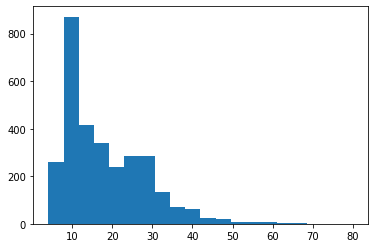

In [112]:
textStatistics(df_medication, "medication")

In [113]:
d_med = detectTypos(df_medication, "medication")

In [116]:
for index, datapoint in d_med.iterrows() :
    print(1, datapoint["s1"])
    print(2, datapoint["s2"])

1 l-carnitine study drug infusion
2 l carnitine study drug infusion
1 l-carnitine study drug infusion
2 lcarnitine study drug infusion 
1 l-carnitine study drug infusion
2 lcarnitine study drug infusion
1 l-carnitine study drug bolus
2 l carnitine study drug bolus
1 l-carnitine study drug bolus
2 l-carnitine study drug bolus 
1 l-carnitine study drug bolus
2 l-carnintin study drug bolus 
1 l-carnitine study drug bolus
2 l-carnitine  study drug bolus 
1 l-carnitine study drug bolus
2 l-carnitine study drug blus
1 vitamin d3/placebo
2 vitamin d3 / placebo
1 vitamin d3/placebo
2 vitamin d3/ placebo
1 vitamin d3/placebo
2 vitamin d3/pacebo
1 vitamin d3/placebo
2 vitma,in d3/placebo
1 vitamin d3/placebo
2 vitamin d 3/placebo 
1 vitamin d3/placebo
2 vitamind3/placebo
1 vitamin d3/placebo
2 vitamin d3 /placebo
1 vitamin d3/placebo
2 vitamin d/placebo
1 vitamin d3/placebo
2 vitamins d3/placebo
1 vitamin d3/placebo
2 vitamine d3/placebo
1 hydrocortisone study drug
2 hydrocortisone study drug 
1

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">
    
Among the `medication` that is not indicated, we are curious as how come this information is missing (since the eMAR is associated with the QRcode of the medication scanned before administration).

1) We extract the `event_txt` labels associated with missing medication name. We find 20 reasons, most of them corresponding to the medication not being actually administered:

- Not confirmed
- Delayed Started
- Delayed Confirmed
- in Other Location
- Stopped As Directed
- Stopped - Unscheduled
- Infusion Reconciliation
- Started in Other Location (9 rows out of 51 rows)
- Stopped in Other Location
- Confirmed in Other Location (5 rows out of 12 rows)
- Not Given per Sliding Scale
- Administered in Other Location (8 rows out of 199 rows)
- Administered Bolus from IV Drip
- Delayed Stopped
- Delayed Not Started
- Delayed Administered
- Partial Administered (1 row out of 40)
- TPN Rate Not Changed (1 row)
- Not Started per Sliding Scale
- Stopped - Unscheduled in Other Location

However this still implies a few missing data, for example even if the data is only partially administered the medication should be indicated. (_in parenthesis is given the number of rows in the database_ emarICUsubset _that have the indicated `event_txt`, and the number of rows among them that have NULL `medication`_).
</div>

In [ ]:
%sql

# 1) distinct event_txt associated with emar data where medication was not administered
SELECT DISTINCT event_txt FROM `iame-int.ICU.emar_emptyMedicationICU_subset`

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

For the purpose of looking at variables studied for **<u>sepsis</u>**, we look at different vasopressors among the distinct values of the `medication` field of the entire ICU related _emar_ data, that is, **17 180 721** rows.
- we obtain results for "vasopressin", "ephinephrine" (=adrenaline), "dobutamine", "norepinephrine" (=noradrenaline)
- note that we obtain several fields that actually refer to ta same medication but include difference in capitalization, number of spaces or punctuation. Morevoer the list **`list_antibio`** of antiobiotics relevant for treatment of sepsis might not be exhaustive, as it would not contain acutal typos, e.g., "vasopresin" for "vasopressin"
- **42 565** or **0.25%** of the rows among the ICU related _emar_ data corresponds to the administration of one of the hereabove mentionned vasopressor
</div>


    SELECT * 
    FROM `physionet-data.mimiciv_3_1_hosp.emar` E
    JOIN `iame-int.ICU.patientICUstays` P
    ON E.hadm_id = P.hadm_id AND E.subject_id = P.subject_id 
    WHERE medication IN ('vasopressin',
     'epinephrine 1:1000',
     'norepinephrine',
     'epinephrine (epipen)',
     'lidocaine 0.5%/epinephrine',
     'lidocaine-epinephrine',
     'lidocaine 1%/epinephrine 1:100,000',
     'epinephrine',
     'lidocaine 1%/epinephrine 1:200,000',
     'epinephrine 1 mg/1 ml',
     'bupivacaine 0.50%-epinephrine',
     'lidocaine 1%/epinephrine 1:100000',
     'racepinephrine',
     'lidocaine 1%/epinephrine 1:200000',
     'lidocaine-epinephrine (pf)',
     'dobutamine',
     'Vasopressin',
     'Lidocaine 1%/Epinephrine 1:100,000',
     'Epinephrine 1:1000',
     'Lidocaine 0.5%/Epinephrine',
     'Lidocaine 1%/Epinephrine 1:200,000',
     'Bupivacaine 0.50%-Epinephrine',
     'Lidocaine 1%/Epinephrine 1:100000',
     'Lidocaine 1%/Epinephrine 1:200000')

In [121]:
df_medication_nocap = normalizeDataframe(df_medication, "medication")
vasopressin = df_medication_nocap[df_medication_nocap.medication.str.contains("vasopressin")]
epinephrine = df_medication_nocap[df_medication_nocap.medication.str.contains("epinephrine")]
dobutamine = df_medication_nocap[df_medication_nocap.medication.str.contains("dobutamine")]
vasopressin2 = df_medication[df_medication.medication.str.contains("Vasopressin")]
epinephrine2 = df_medication[df_medication.medication.str.contains("Epinephrine")]
dobutamine2 = df_medication[df_medication.medication.str.contains("Dobutamine")]

list_antibio = vasopressin.medication.tolist() + epinephrine.medication.tolist() + dobutamine.medication.tolist() + vasopressin2.medication.tolist() + epinephrine2.medication.tolist() + dobutamine2.medication.tolist()
list_antibio

['vasopressin',
 'epinephrine 1:1000',
 'norepinephrine',
 'epinephrine (epipen)',
 'lidocaine 0.5%/epinephrine',
 'lidocaine-epinephrine',
 'lidocaine 1%/epinephrine 1:100,000',
 'epinephrine',
 'lidocaine 1%/epinephrine 1:200,000',
 'epinephrine 1 mg/1 ml',
 'bupivacaine 0.50%-epinephrine',
 'lidocaine 1%/epinephrine 1:100000',
 'racepinephrine',
 'lidocaine 1%/epinephrine 1:200000',
 'lidocaine-epinephrine (pf)',
 'dobutamine',
 'Vasopressin',
 'Lidocaine 1%/Epinephrine 1:100,000',
 'Epinephrine 1:1000',
 'Lidocaine 0.5%/Epinephrine',
 'Lidocaine 1%/Epinephrine 1:200,000',
 'Bupivacaine 0.50%-Epinephrine',
 'Lidocaine 1%/Epinephrine 1:100000',
 'Lidocaine 1%/Epinephrine 1:200000']

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

### **<u>Emar detail:</u>** the _emar_detail_ table  (_hosp_ module)

_emar_detailICUsubset_ has **96 594** rows.
</div>

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

`emar_id`

- In average in the _emar_detailICUsubset_ (obtained from the joining the _emarICusubset_ on _emar_detail_, see before), `emar_id` (rows in _emar_) have **1.93** associated rows in _emar_detail_, ranging from **1** to **17**
- **11 422** `emar_id` have only one associated row in _emar_detailICUsubset_, which represents (11422/50000) **22.84%** (_to compute the percentage, the denominator is 50000 because that is the number of `emar_id`'s = the number of rows in emarICUsubset_)
- **64.67%** of `emar_id` have 2 associated rows in _emar_detailICUsubset_ (**32336** `emar_id`'s), **22.84%** have **1**, and **10.14%** have **3** (**5071** `emar_id`'s).
</div>

<span style="color:silver">\# statistics on the number of rows in emar detail for each emar_id</span>

    SELECT MIN(emar_count), MAX(emar_count), AVG(emar_count)
    FROM (
      SELECT emar_id, COUNT(*) AS emar_count
      FROM `iame-int.ICU.emar_detailICUsubset`
      GROUP BY emar_id
    )

<span style="color:silver">\# number of emar_id from emarICUsubset that only have one associated row in emar_detail</span>

    SELECT emar_id, COUNT(*) AS emar_count
    FROM `iame-int.ICU.emar_detailICUsubset`
    GROUP BY emar_id
    HAVING emar_count = 1

<span style="color:silver">\# the three main number of rows in emar_detailICUsubset for an emar_id</span>

    SELECT emar_count, COUNT(*) AS emar_count_count # the number of times a value for emar_count appears
    FROM (
      SELECT COUNT(*) AS emar_count # the number of rows in emar detail per emar_id
      FROM `iame-int.ICU.emar_detailICUsubset`
      GROUP BY emar_id
    )
    GROUP BY emar_count
    ORDER BY emar_count_count DESC
    LIMIT(3) 

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

- Among the 96 594 rows of _emar_detailICUsubset_, **46 596** have empty `administration_type`
- There are **19** distinct values of `administration_type` (including null). We visually check that all administration types are unique (no problem with capitalization


- **!** in a lot of cases, when the `administration_type` is null, the `parent_field_ordinal` is not (only 3 rows have both field null, otherwise for all the rest, null `administration_type` implies non-null `parent_field_ordinal`. Moreover the 3 rows that have both fields null are also for the rest mainly empty)


- In the _emar_detailICU_ table, **50 000** rows have an empty `parent_original_field`. This is consistent with the number of `emar_id`'s in _emarICUsubset_ (each `emar_id` must have at least one row with that field empty as it is the first administration. This is consistent with the fact that **49 997** only among the rows that have  `parent_original_field` empty also have `administration_type` empty. **interpretation:** we can make a generalization that if an `emar_id` has several associated emar_detail information, the first associated line will have `parent_original_field` null and will indicate the administration type. The other associated rows, with non-null `parent_original_field`, should have the same administration type as the first row. There are only **3** rows not following this rule, the 3 ones mentionned above.

**`df_administration_type` is the list of distinct values for `administration_type` and their count in the _emar_detailICUsubset_ table**
</div>

In [85]:
df_administration_type = pd.read_csv('../Data/MIMIC-IV/emar_detailICU_distinct_administration_types.csv')
df_administration_type

,administration_type,count_admin_type
0,NaN,46597
1,Argatroban IV Infusion,10
2,Bolus Dose from IV Drip,1076
3,Epidural,16
4,Heparin IV Infusion,331
5,IV Fluid Repletion,1
6,IV Flush,140
7,IV Infusion,3986
8,Insulin Infusion (IV Drip),153
9,Insulin SC Fixed Dose,18


<span style="color:silver">\# number of times each administration type was registered in emar_detailICUsubset</span>

    SELECT administration_type, COUNT(*) AS count_admin_type
    FROM `iame-int.ICU.emar_detailICUsubset` 
    GROUP BY administration_type
    ORDER BY administration_type ;

<span style="color:silver">\# count of null administration types</span>

    SELECT COUNT(*)
    FROM `iame-int.ICU.emar_detailICUsubset` 
    WHERE administration_type IS NULL

<span style="color:silver">\# in emar_detailICUsubset, rows where both administration_type and parent_field_ordinal are null. result is 3</span>

    SELECT COUNT(*)
    FROM `iame-int.ICU.emar_detailICUsubset` 
    WHERE administration_type IS NULL 
    AND parent_field_ordinal IS NULL 

<span style="color:silver">\# the 3 rows that have both fields null</span>

    SELECT *
    FROM `iame-int.ICU.emar_detailICUsubset` 
    WHERE administration_type IS NULL 
    AND parent_field_ordinal IS NULL

<span style="color:silver">\# number of rows in emar_detailICUsubset where the parent_ordinal_field is null</span>

    SELECT COUNT(*) FROM `iame-int.ICU.emar_detailICUsubset` WHERE parent_field_ordinal IS NULL

<span style="color:silver">\# rows where administration_type is not null but parent_field_ordinal is</span>

    SELECT *
    FROM `iame-int.ICU.emar_detailICUsubset` 
    WHERE administration_type IS NOT NULL 
    AND parent_field_ordinal IS NULL

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

In general, we note that the _emar_detailICUsubset_ has a lot of null fields. 
_This might be due to the fact that there are a lot of fields in the table (**33**) giving more precise information about the medication administration. However among those field, some don't apply to all types of medication (for example, transdermal patch don't have an infusion_rate_. see example).

so in **<u>emar_detailICUsubset</u>**:

- `subject_id`
- `emar_id`
- `emar_seq`
- `parent_field_ordinal`
- `administration_type`


- `pharmacy_id` (_we have computed above the number of erroneous `pharmacy_id` fields. **50 689** rows have an empty `pharmacy_id` field, and most of them (**50 145**) correspond to an empty `barcode_type`)_. **There are 143 joined rows where the row in _emarICU_ and a corresponding row in _emar_detailICU_ don't have the same `pharmacy_id`. It is always linked to the same medication in the _pharmacy_ table. **!!** They always corespond to `parent_original_field` being non-empty, thus a second administration of the medicament. 
- By curiosity, we look at `emar_id` having different `pharmacy_id`'s. Overall, **31 776** `emar_id`'s have only one associated `pharmacy_id`, which is way more than the number of `emar_id`'s that have only one associated emar_detail row (11 422). **12042** simply don't have an associated `pharmacy_id` in _emar_detail_, and **6 182** have 2 or more associated `pharmacy_id`'s. 
- we have computed before that **50 689** rows in _emar_detail_ don't have a `pharmacy_id` field. Among those, **12731** don't have a `pharmacy_id` in _emar_ either. 


- `barcode_type` (**53.93%** empty)
- `reason_for_no_barcode` (among rows with `barcode_type` null, **95.99%** have `reason_for_no_barcode` empty as well)
- `complete_dose_not_given` (null **91.86%** of the rows, "no" (equivalent to null) **8.08%** of the rows, "yes" **0.06%** of the rows)


- `dose_due` (null **52.74%** of the rows)
- `dose_due_unit` (among the non-null dose_due rows, null **0.16%** of the rows. in general, if `dose_due` is indicated, then so is the unit)
- `dose_given` (null **55.34%** of the rows)
- `dose_given_unit` (among the non-null `dose_given` rows, null **0.03%** of the rows. In general, if `dose_given` is indicated, then so is the unit)
- `will_remainder_of_dose_be_given` (empty **90.25%** of the time. when not empty, **6.26%** have both `dose_due` and `dose_given null`)


- `product_amount_given` (null **62.57%** of the rows)
- `product_unit`
- `product_code` (null **54.69%** of the rows)
- `product_description`
- `product_description_other`


- `prior_infusion_rate`
- `infusion_rate`
- `infusion_rate_adjustment`: this can take **9** values, including null (which represents **95 161** rows or **98.52%** of the rows). Moreover, 2 of these possible values indicates no change ("No Change In Rate" and "Initial Rate") ad represent **0.16%**.
- `infusion_rate_adjustment_amount`: _this feature has only 4 non-null rows. There is redundancy in the table as this feature can be deduced from comparing `infusion_rate` and `infusion_rate_adjustment_amount` (`infusion_rate_adjustment` indicates whether the adjustment is "decrease" or "increase", but this can also be deduced from the two mentionned variables).
- `infusion_rate_unit`
- `route` (null **86.93%** of the rows. Otherwise route is "NG", "PO", " ng", "ng", or "po" (nasogastric or per os=orally) so this is not consistent. **11.59%** of the rows po so **1.48%** nasogastric)
- `infusion_complete` (null **97.24%** of the rows)
- `completion_interval` (null **99.90%** of the rows)


- `new_iv_bag_hung` (null 99.95% of the time, "Y" the rest of the time)
- `continued_infusion_in_other_location` **NULL 100% OF THE ROWS** 
- `restart_interval`
- `side` (null **99.86%** of the rows, "right" **0.05%**, "left" **0.07**, "center" **0.02**)
- `site` (null or "---" **99.88%** of the rows)
- `non_formulary_visual_verification` (null **99.92%** of the time, "Y" else)
</div>

<span style="color:silver">\# we use this query on each of the different feature_name to obtain the list of distinct values and the percentage they represent <span>
    
    SELECT feature_name, 100 * COUNT(*) / 96594
    FROM `iame-int.ICU.emar_detailICUsubset`
    GROUP BY feature_name

<span style="color:silver">\#example transdermal patch and infusion rate</span>

    SELECT * FROM `iame-int.ICU.emar_detailICUsubset`
    WHERE administration_type = "Transdermal Patch"
    AND infusion_rate IS NOT NULL

<span style="color:silver">\# comparison of the pharmacy_id's in emar and emar_detail, and the medication</span>

    SELECT E.pharmacy_id, E.medication,
      ED.pharmacy_id, ED.product_description, 
    FROM `iame-int.ICU.emarICUsubset` E
    JOIN `iame-int.ICU.emar_detailICUsubset` ED
    ON E.emar_id=ED.emar_id

<span style="color:silver">\# identification of data in emar and emar_detail that have different pharmacy id's </span>

    SELECT E.emar_id, E.pharmacy_id, E.medication,
      ED.pharmacy_id, ED.product_description, ED.parent_field_ordinal
    FROM `iame-int.ICU.emarICUsubset` E
    JOIN `iame-int.ICU.emar_detailICUsubset` ED
    ON E.emar_id=ED.emar_id
    WHERE E.pharmacy_id != ED.pharmacy_id

<span style="color:silver">\# emar_id with diff pharmacy_id in emar_detailICUsubset</span>

<span style="color:silver">\# count of the number of diff pharmacies emar_id's have (ex: 10 emar_id have 4 diff associated pharmacy_id's) </span>

    SELECT count_pharmacy_per_emar, COUNT(*) AS count_count
    FROM (
      SELECT emar_id, COUNT(pharmacy_id) AS count_pharmacy_per_emar
      FROM `iame-int.ICU.emar_detailICUsubset`
      GROUP BY emar_id
      ORDER BY count_pharmacy_per_emar
    )
    GROUP BY count_pharmacy_per_emar
    ORDER BY count_count DESC

<span style="color:silver">\# empty pharmacy fields</span>

<span style="color:silver">\# we take the emar_id in emar_detailICU that don't have an associated pharmacy and we look at whether they do have a pharmacy_id in emar</span>

    SELECT E.emar_id, E.pharmacy_id FROM (
      SELECT emar_id FROM `iame-int.ICU.emar_detailICUsubset`
      WHERE pharmacy_id IS NULL 
    ) ED JOIN `iame-int.ICU.emarICUsubset` E ON E.emar_id = ED.emar_id

<span style="color:silver">\# infusion_rate_adjustment</span>

    SELECT infusion_rate_adjustment, COUNT(*) FROM `iame-int.ICU.emar_detailICUsubset` GROUP BY infusion_rate_adjustment

<span style="color:silver">\# infusion_rate_adjustement_amount</span>

    SELECT * FROM `iame-int.ICU.emar_detailICUsubset` WHERE infusion_rate_adjustment_amount IS NOT NULL

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

As consistency of unit can be quite important when comparing values, and the _emar_detail_ has 4 different unit features (which are string features), we look at the coherence of the termns used in each of them.

**`df_dose_given_UNTIS` is the csv file of all distinct values of `dose_given_unit`. `df_dose_due_UNITS` is the csv file of all distinct values of `dose_due_unit`. `df_products_UNITS` is the csv file of all distinct values of `product_unit`. `df_infusion_rate_UNITS` is the csv file of all distinct values of `infusion_rate_unit`. We extract all of these from the subtable _emar_detailICUsubset_**.

`dose_given_unit`
- 61 distinct values
- 9 different capitalizations
- 1 value with extra spaces
- 1 detected typo

`dose_due_unit`
- 78 distinct values
- 14 different capitalizations
- 1 value with extra spaces
- 0 detected typo

`product_unit`
- 36 distint values
- 2 different capitalizations
- 0 value with extra spaces
- 0 detected typo

`infusion_rate_unit`
- 11 distinct values
- 1 different capitalizations
- 0 value with extra spaces
- 0 detected typo

Observe that among all the units, there are other inconsistencies: both "g" and "gm" are used for "grams". There are also "units" that seem to rather refer to other concepts, seem to be unique to one medication, or don't necessairly indicate the volume (_such as vial_)
- | dose_given | 
- | dose_due | 
- | product | PTCH, UDCUP, vial, BTL, 
- | infusion_rate | 
</div>

<span style="color:silver">\# dose_given_unit</span>

    SELECT DISTINCT (dose_given_unit) FROM `iame-int.ICU.emar_detailICUsubset`

<span style="color:silver">\# dose_due_unit</span>

    SELECT DISTINCT (dose_due_unit) FROM `iame-int.ICU.emar_detailICUsubset`

<span style="color:silver">\# product_unit</span>

    SELECT DISTINCT (product_unit) FROM `iame-int.ICU.emar_detailICUsubset`

<span style="color:silver">\# infusion_rate_unit</span>

    SELECT DISTINCT (infusion_rate_unit) FROM `iame-int.ICU.emar_detailICUsubset`

In [87]:
df_dose_given_UNITS = pd.read_csv('../Data/MIMIC-IV/emar_detailICU_dose_given_UNITS.csv')
df_dose_due_UNITS = pd.read_csv('../Data/MIMIC-IV/emar_detailICU_dose_due_UNITS.csv')
df_product_UNITS = pd.read_csv('../Data/MIMIC-IV/emar_detailICU_product_UNITS.csv')
df_infusion_rate_UNITS = pd.read_csv('../Data/MIMIC-IV/emar_detailICU_infusion_rate_UNITS.csv')

In [88]:
dose_given_CAPcount = countCapitalization(df_dose_given_UNITS, "dose_given_unit")
dose_due_CAPcount = countCapitalization(df_dose_due_UNITS, "dose_due_unit")
product_CAPcount = countCapitalization(df_product_UNITS, "product_unit")
infusion_rate_CAPcount = countCapitalization(df_infusion_rate_UNITS, "infusion_rate_unit")

print(f'The number of values in the dose_given_unit that appear with different capitalization is {dose_given_CAPcount["diff_distinct_decap"]}')
print(f'The number of values in the dose_due_unit that appear with different capitalization is {dose_due_CAPcount["diff_distinct_decap"]}')
print(f'The number of values in the product_unit that appear with different capitalization is {product_CAPcount["diff_distinct_decap"]}')
print(f'The number of values in the infusion_rate_unit that appear with different capitalization is {infusion_rate_CAPcount["diff_distinct_decap"]}')

The number of values in the dose_given_unit that appear with different capitalization is 9
The number of values in the dose_due_unit that appear with different capitalization is 14
The number of values in the product_unit that appear with different capitalization is 2
The number of values in the infusion_rate_unit that appear with different capitalization is 1


In [91]:
dose_given_SPcount = countExtraSpaces(df_dose_given_UNITS, "dose_given_unit")
dose_due_SPcount = countExtraSpaces(df_dose_due_UNITS, "dose_due_unit")
product_SPcount = countExtraSpaces(df_product_UNITS, "product_unit")
infusion_rate_SPcount = countExtraSpaces(df_infusion_rate_UNITS, "infusion_rate_unit")

print(f'The number of values in the dose_given_unit that appear with different spaces is {dose_given_SPcount["diff_distinct_nosp"]}')
print(f'The number of values in the dose_due_unit that appear with different spaces is {dose_due_SPcount["diff_distinct_nosp"]}')
print(f'The number of values in the product_unit that appear with different spaces is {product_SPcount["diff_distinct_nosp"]}')
print(f'The number of values in the infusion_rate_unit that appear with different spaces is {infusion_rate_SPcount["diff_distinct_nosp"]}')

The number of values in the dose_given_unit that appear with different spaces is 1
The number of values in the dose_due_unit that appear with different spaces is 1
The number of values in the product_unit that appear with different spaces is 0
The number of values in the infusion_rate_unit that appear with different spaces is 0


In [92]:
dose_given_typo = detectTypos(df_dose_given_UNITS, "dose_given_unit")
dose_due_typo = detectTypos(df_dose_due_UNITS, "dose_due_unit")
product_typo = detectTypos(df_product_UNITS, "product_unit")
infusion_rate_typo = detectTypos(df_infusion_rate_UNITS, "infusion_rate_unit")


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**<u>pharmacy:</u>** the _pharmacy_ table

The entire ICU-related data within _pharmacy_ can be obtained through a join on _patientICUstays_ and consists of **6 991 416** rows

First note that a unique `pharmacy_id` can appear several times in _emar_, since one `emar_id` can be associate with several `emar_seq`.

Moreover, in the previoulsy computed _pharmacyICUsubset_, several pharmacy id's appear severa times (because the pharmacies may be referenced several times as well in _emar_). For the computation, we thus extract the distinct pharmacies (see query 1), and perform the computation using the temporary result table.
</div>

<span style="color:silver">\# all the ICU related data in the pharmacy table. From the result of this query we obtain the total number of pharmacy rows for ICU admissions. We also extract the distinct medications </span>

    SELECT *
    FROM `physionet-data.mimiciv_3_1_hosp.pharmacy` E
    JOIN `iame-int.ICU.patientICUstays` P
    ON E.hadm_id = P.hadm_id AND E.subject_id = P.subject_id 

<span style="color:silver">\# query 1)</span>
    SELECT DISTINCT * FROM `iame-int.ICU.pharmacyICUsubset`

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**<u>Null values</u>** and **<u>value counts</u>**

- `medication` : **1.48** of null values. Otherwise the five most represented medications are "OxyCODONE (Immediate Release)" (**9.30%**), "Chlorhexidine Gluconate 0.12% Oral Rinse" (**5.21%**), "HYDROmorphone (Dilaudid)" (**4.54%**), "Fentanyl Citrate" (**3.70%**) and "Ipratropium-Albuterol Neb" (**2.99%**). **36** medication values appear with different capitalization.
- `proc_type` : never null. **81.46%** of "Unit Dose" and **17.17%** of "IV Piggyback"
- `status` : never null 
- `entertime` and `verified_time` : never null, and it is <u>always</u> true that `entertime` <= `verifiedtime`
- `starttime` is never null, `endtime` is null **24** times (**0.07%** only). All rows with null `stoptime` correspond to null `medication`, `route`, and all following rows, with "TPN" `proc_type` and "expired" `status`. Observe that "TPN" only appears **27** times, so for most of the corresponding rows we have empty data. **And** for **52** rows, we have `stoptime` > `starttime` which is not coherent. 
</div>

<span style="color:silver">\# with result table from query 1</span>

<span style="color:silver">\# we use the following query to compute the disintct values for different feature_name and their frequency in the database (includes null values)</span>

    SELECT feature_name, 100 * COUNT(*) / (SELECT COUNT(*) FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon58505c380eb81f9cb7e62c8a7d2b5bace4d40a344ce24a0ac03b703ed8064acd`) AS percentage
    FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon58505c380eb81f9cb7e62c8a7d2b5bace4d40a344ce24a0ac03b703ed8064acd` 
    GROUP BY feature_name
    ORDER BY percentage DESC

<span style="color:silver">\# example of above query with route_type</span>

    SELECT route, 100 * COUNT(*) / (SELECT COUNT(*) FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon58505c380eb81f9cb7e62c8a7d2b5bace4d40a344ce24a0ac03b703ed8064acd`) AS percentage
    FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon58505c380eb81f9cb7e62c8a7d2b5bace4d40a344ce24a0ac03b703ed8064acd` 
    GROUP BY route
    ORDER BY percentage DESC

<span style="color:silver">\# times coherence</span>

    SELECT *
    FROM `soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon58505c380eb81f9cb7e62c8a7d2b5bace4d40a344ce24a0ac03b703ed8064acd`
    WHERE starttime > stoptime
    AND stoptime IS NOT NULL

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

`medication` in the _pharmacy_ table

**`df_pharma_medication` is the csv file of all distinct medications in the ICU related _pharmacy_ table**

- `medication` has **5 612** distinct values 
- But **4 735** medication names simply appear with different capitalization. 
- Morevoer, the medication values "1" and "2" appear as well which seems to be an error. 
- There is also one composed medication name that appears with the two composents in different order ("a-b" VS "b-a")
- There are **184** values of medication with different number of spaces
- we detect over **232** typos
</div>

In [81]:
df_pharma_medication = pd.read_csv("../Data/MIMIC-IV/pharmacyICU_distinctmedication.csv")
pharma_medication = pd.DataFrame(df_pharma_medication['medication'].dropna())
countCapitalization(pharma_medication, "medication")

{'initial_count': 5612,
 'decap_count': 4735,
 'diff_distinct_decap': 877,
 'list_df_diff_cap': ['phenobarb',
  'Esmolol',
  'Insulin',
  'Ketamine',
  'Labetalol',
  'EPINEPHrine',
  'hydrochlorothiazide',
  'escitalopram oxalate',
  'amphetamine-dextroamphetamine',
  'scopolamine HBr',
  'Calcium',
  'flecainide',
  'Lorazepam',
  'GuaiFENesin',
  'Guaifenesin',
  'HydrALAZINE',
  'HydrALAzine',
  'Simethicone',
  'Diazepam',
  'Ibuprofen',
  'Ketorolac',
  'LORazepam',
  'Hydrocodone-Acetaminophen',
  'OLANZapine (Disintegrating Tablet)',
  'DiphenhydrAMINE',
  'OxyCODONE (Immediate Release)',
  'Heparin',
  'ValGANCIclovir',
  'QUEtiapine Fumarate',
  'Senna',
  'Bisacodyl',
  'Ramelteon',
  'TraZODone',
  'Guaifenesin-CODEINE Phosphate',
  'HYDROcodone-Acetaminophen (5mg-325mg)',
  'Ipratropium-Albuterol Inhalation Spray',
  'Metoprolol Tartrate',
  'Diphenoxylate-Atropine',
  'Ipratropium Bromide Neb',
  'Guaifenesin-Dextromethorphan',
  'Acetaminophen',
  'Glycopyrrolate',
  'Mi

In [82]:
suspi_med = detectTypos(normalizeDataframe(pharma_medication, "medication"), "medication")

KeyboardInterrupt: 

In [134]:
print(len(suspi_med))
for index, datapoint in suspi_med[50:].iterrows() :
    print("s1", datapoint["s1"])
    print("s2", datapoint["s2"])

716
s1 budesonide 0.5mg 
s2 budesonide 0.5mg
s1 chlorpromazine
s2 chlorpromazin
s1 desogestrel-ethinyl estradiol
s2 levonorgestrel-ethinyl estrad
s1 nmb (0.9% nacl 100 ml)
s2 nmb (0.9% nacl 100ml)
s1 voltaren gel 1%
s2 voltaren 1% gel
s1 calcium gluconate
s2 calcium gluconate 
s1 nimodipine 60mg
s2 nimodipine 30mg
s1 heparin flush (10 units/ml)
s2 heparin flush (100 units/ml)
s1 heparin flush (10 units/ml)
s2 heparin flush (1000 units/ml)
s1 heparin flush (10 units/ml)
s2 heparin flush (5000 units/ml)
s1 atorvastatin 40 mg
s2 atorvaststin 40 mg
s1 coq10 200mg caps
s2 coq10 200 mg cap
s1 cortroysn
s2 cortrosyn
s1 cortroysn
s2 cortroysn 
s1 cortroysn
s2 cortroyson
s1 domperidone
s2 domperidone 
s1 epinephrine 
s2 epinephrine
s1 humulin r u-500 concentrated
s2 humulin r u-500 (concentrated)
s1 vancomycin 
s2 vancomycin
s1 sodium bica
s2 sodium bic
s1 sodium bica
s2 sodium bicar
s1 latuda (lurasidone)
s2 lurasidone (latuda)
s1 hydrocodone-acetaminophen (5mg-325mg)
s2 hydrocodone-acetaminop

In [123]:
countExtraSpaces(df_pharma_medication, "medication")

{'initial_count': 5612,
 'nospace_count': 5428,
 'diff_distinct_nosp': 184,
 'list_df_diff_nosp': ['Morphine Sulfate',
  'Insulin',
  'Ketamine',
  'Midazolam',
  'Furosemide',
  'EPINEPHrine',
  'Calcium',
  'methotrexate ',
  'OxycoDONE (Immediate Release) ',
  'Heparin',
  'ValGANCIclovir',
  'Acetaminophen',
  'Amiodarone',
  'Alteplase',
  'Lidocaine',
  'Oxycodone-Acetaminophen',
  'Calcium Gluconate',
  'Epinephrine',
  'Dexamethasone',
  'Multivitamins',
  'Venlafaxine',
  'Potassium Chloride',
  'Clopidogrel',
  'Lidocaine 1%',
  'Aminocaproic Acid',
  'Ranitidine',
  'Aminocaproic Acid 25 % Oral Rinse',
  'Tacrolimus',
  'Methadone',
  'Hydrocortisone',
  'Albumin 5%',
  'Morphine ',
  'Deferoxamine',
  'ValGANCIclovir ',
  'Sodium Chloride',
  'Lithium Carbonate',
  'Niacinamide',
  'Melatonin ',
  'PHENObarbital',
  'thiamine',
  'Docusate',
  'Albumin 25%',
  'Symbicort',
  'lidocaine',
  'Sarilumab 400mg/200mg',
  'Ciprofloxacin',
  'Thiamine',
  'Phenytoin',
  'Citalopra

21.903658536585365 1 75


('Outliers:',
 ['Magnesium Sulfate Replacement (Critical Care and Oncology)',
  'Potassium Chloride Replacement (Critical Care and Oncology)',
  'Potassium Chloride Replacement (Critical Care and Oncology) ',
  'Calcium Gluconate sliding scale (Critical Care-Ionized calcium)',
  'Alteplase 1mg/2mL ( Clearance ie. PICC, midline, tunneled access line, PA )',
  'Alteplase 1mg/2mL ( Clearance ie. PICC, tunneled access line )',
  'Alteplase 1mg/2mL ( Clearance ie. PICC, tunneled access line, PA )',
  'PHENObarbital - ICU Alcohol Withdrawal (Initial Load / Rescue Dose)',
  'Alteplase 1mg/Flush Volume ( Dialysis/Pheresis Catheters )',
  'Acetylcysteine Inhaled – For interventional pulmonary use only',
  'Vancomycin (2 mg/mL)-Heparin (10 units/mL) Lock *STANDARD*'])

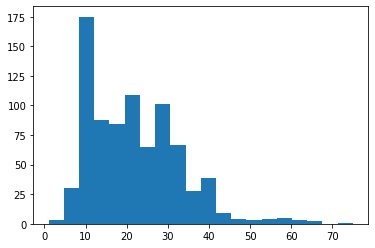

In [247]:
textStatistics(df_pharma_medication, "medication")

In [251]:
print([feature for feature in df_pharma_medication.dropna()["medication"] if len(feature)<5])
print([feature for feature in df_pharma_medication.dropna()["medication"] if len(feature)>70])

['1', '2', 'APAP']
['Alteplase 1mg/2mL ( Clearance ie. PICC, midline, tunneled access line, PA )']


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

Now we look into the antibiotics given in _pharmacy_

- among the ICU related rows, **48 918** or **0.7%** of the rows have medication administration corresponding to one of the <mark>vasopressors</mark> identified hereafter
- we also find the administration of essential <mark>fluids</mark> such as sodium chloride or albumin (see **`fluids`** list), which correspond to **528 435** or **7.56%** of the rows
</div>

In [156]:
df_pharma_medication[df_pharma_medication.medication.str.contains("ampicillin")]

,medication
3928,ampicillin sodium


In [145]:

v1 = df_pharma_medication[df_pharma_medication.medication.str.contains("vasopressin")]
v2 = df_pharma_medication[df_pharma_medication.medication.str.contains("epinephrine")]
v3 = df_pharma_medication[df_pharma_medication.medication.str.contains("dobutamine")]
v4 = df_pharma_medication[df_pharma_medication.medication.str.contains("Vasopressin")]
v5 = df_pharma_medication[df_pharma_medication.medication.str.contains("Epinephrine")]
v6 = df_pharma_medication[df_pharma_medication.medication.str.contains("Dobutamine")]

vasopressor = a1["medication"].tolist()+a2["medication"].tolist()+a3["medication"].tolist()+a4["medication"].tolist()+a5["medication"].tolist()+a6["medication"].tolist()
vasopressor

['NORepinephrine',
 'Norepinephrine',
 'Racepinephrine',
 'NORepinephrine (in NS)',
 'NORepinephrine ((for dil 8mg KIT',
 'Racepinephrine 2.25% Soln',
 'lidocaine-epinephrine',
 'Racepinephrine 0.5mL Neb',
 'NORepinephrine ((for dilution)',
 'lidocaine-epinephrine (PF)',
 'Vasopressin',
 'Vasopressin (for dilution)',
 'Vasopressin (for 40units/2mL 2mL',
 'Epinephrine HCl',
 'Epinephrine 1:1000',
 'Epinephrine',
 'Lidocaine 0.5%/Epinephrine',
 'Lidocaine 1%/Epinephrine 1:100000',
 'Lidocaine 1%/Epinephrine 1:100,000',
 'Bupivacaine 0.25%-Epinephrine',
 'Lidocaine 1%/Epinephrine 1:200,000',
 'Lidocaine 2%/Epinephrine',
 'Lidocaine 2%/Epinephrine P.F.',
 'Bupivacaine 0.50%-Epinephrine',
 'Epinephrine Auto Injector',
 'Lidocaine 1%/Epinephrine 1:200000',
 'Epinephrine ',
 'Epinephrine Topical Soln',
 'Epinephrine Base',
 'Lidocaine 1.5%/Epinephrine P.F.',
 'Epinephrine Kit',
 'Lidocaine 1%/Epinephrine']

In [84]:
decap_df_pharma_medication = df_pharma_medication.copy()
decap_df_pharma_medication["decap_medication"] = df_pharma_medication['medication'].str.lower()
f_sod = decap_df_pharma_medication[decap_df_pharma_medication.decap_medication.str.contains("sodium")&decap_df_pharma_medication.medication.str.contains("chloride")&decap_df_pharma_medication.medication.str.contains("9")]

f3 = df_pharma_medication[df_pharma_medication.medication.str.contains("ringer")]
f4 = df_pharma_medication[df_pharma_medication.medication.str.contains("lactate")]
f5 = df_pharma_medication[df_pharma_medication.medication.str.contains("albumin")]
f6 = df_pharma_medication[df_pharma_medication.medication.str.contains("Albumin")]

fluids = f3.medication.tolist() + f4.medication.tolist() + f5.medication.tolist() + f6.medication.tolist()
fluids += f_sod.medication.tolist()
fluids

['IV Lactated ringers w/ mvi',
 'ammonium lactate',
 'albumin 5',
 'albumin 5%',
 'albumin',
 'Albumin 5% (25g / 500mL)',
 'Albumin 5% (12.5g / 250mL)',
 'Albumin 25% (12.5g / 50mL)',
 'Albumin 5%',
 'Albumin 25%',
 'Albumin 5% ',
 'Albumin ',
 'Albumin 5',
 'Albumin 25% (25g /100mL)',
 'Albumin',
 'Albumin 5% )',
 'Albumin 25% ',
 'Albumin 5% 12.5g/250mL 250mL BAG',
 'Albumin 5% (',
 'sodium chloride 0.9%',
 'Sodium chloride 0.9%',
 'sodium chloride 0.9 % (flush)']

    SELECT * 
    FROM `physionet-data.mimiciv_3_1_hosp.pharmacy` P
    JOIN `iame-int.ICU.patientICUstays` I
    ON P.subject_id = I.subject_id AND P.hadm_id = I.hadm_id
    WHERE medication IN ('NORepinephrine',
     'Norepinephrine',
     'Racepinephrine',
     'NORepinephrine (in NS)',
     'NORepinephrine ((for dil 8mg KIT',
     'Racepinephrine 2.25% Soln',
     'lidocaine-epinephrine',
     'Racepinephrine 0.5mL Neb',
     'NORepinephrine ((for dilution)',
     'lidocaine-epinephrine (PF)',
     'Vasopressin',
     'Vasopressin (for dilution)',
     'Vasopressin (for 40units/2mL 2mL',
     'Epinephrine HCl',
     'Epinephrine 1:1000',
     'Epinephrine',
     'Lidocaine 0.5%/Epinephrine',
     'Lidocaine 1%/Epinephrine 1:100000',
     'Lidocaine 1%/Epinephrine 1:100,000',
     'Bupivacaine 0.25%-Epinephrine',
     'Lidocaine 1%/Epinephrine 1:200,000',
     'Lidocaine 2%/Epinephrine',
     'Lidocaine 2%/Epinephrine P.F.',
     'Bupivacaine 0.50%-Epinephrine',
     'Epinephrine Auto Injector',
     'Lidocaine 1%/Epinephrine 1:200000',
     'Epinephrine ',
     'Epinephrine Topical Soln',
     'Epinephrine Base',
     'Lidocaine 1.5%/Epinephrine P.F.',
     'Epinephrine Kit',
     'Lidocaine 1%/Epinephrine')

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

`frequency` in _pharmacy_

**`df_pharma_frequency` is the list of all distinct frequencies in _pharmacyICUsubset_**

- **0** problem with capitalization
- **0** detected typos
- **3** values for frequencies that are written differently but correspond to the same frequency. 
- Morevoer observe that both "4X/DAY" and "QID" refer to 4 times a day, or "X1" and "1X" refer to once a day. Frequencies should be checked when working with them, in order to not categorize them differently when they acutally refer to the same. 

_Here for example, the list of 90 distinct frequencies actually refers to max 85 frequencies_.
</div>

In [104]:
df_pharma_frequency = pd.read_csv("../Data/MIMIC-IV/pharmacyICU_frequencies.csv")
pharma_frequency = pd.DataFrame(df_pharma_frequency['frequency'].dropna())

# first we apply the function for letter caps
countCapitalization(pharma_frequency, "frequency")

{'initial_count': 90,
 'decap_count': 90,
 'diff_distinct_decap': 0,
 'list_df_diff_cap': []}

In [108]:
countExtraSpaces(pharma_frequency, "frequency")

{'initial_count': 90,
 'nospace_count': 87,
 'diff_distinct_nosp': 3,
 'list_df_diff_nosp': ['Q8H', 'Q12H', 'Q24H', 'Q 12H', 'Q 8H', 'Q 24H']}

In [109]:
detectTypos(pharma_frequency, "frequency")

,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,x1,1x,50,50,50,0.000000
1,q1h per moviprep protocol,q2h per moviprep protocol,96,96,96,0.089087
2,once per lumen (2 lumen),once per lumen (1 lumen),96,95,94,0.091287
3,once per lumen (2 lumen),once per lumen (3 lumen),96,95,94,0.091287
4,q15min:prn,q5min:prn,95,95,95,0.147477
5,once per lumen (1 lumen),once per lumen (3 lumen),96,95,94,0.091287


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

### **<u>Prescriptions:</u>** the _prescriptions_ table (or _prescriptionICUsubset_)  (_hosp_ module)

- **44 288** rows 
- **872** distinct drugs 
- but **31** appear with different capitalizations
- there are also **4** that appear with extra spaces and that might get classified differently 
- finally, in typo detection, we note **7** rows that are equivalent, due to extra periods ("hydrocortisone na succ." and "hydrocortisone na succ"), different abbreviations ("methylprednisolone sodium succ" and "methylprednisolone sod succ"), order of words ("dextrose 5%" and "5% dextrose"), compound words ("dextromethorphan-guaifenesin (sugar free)" and "guaifenesin-dextromethorphan (sugar free)"), extra hyphens ("oxycodone--acetaminophen (5mg-325mg)" and "oxycodone-acetaminophen (5mg-325mg)"). When manually checking we have to remove the flagged values that only have a different number of spaces.

Which means that the 872 "distinct" drugs in the table actually correspond (at elast semantically speaking, there might be more row equivalences in terms of medical meaning) to **830** distinct drugs only (+ if the algorithm did not detect extra errors)

**`df_prescriptionsdrugs` is a csv file of all drugs in _prescriptionICUsubset_**.
</div>

<span style="color:silver">\# drug in the prescription tables and their frequency in prescriptionICUsubset</span>

    SELECT drug, 100*COUNT(*)/(SELECT COUNT(*) FROM `iame-int.ICU.prescriptionICUsubset`) 
    FROM `iame-int.ICU.prescriptionICUsubset`
    GROUP BY drug

In [110]:
df_prescriptionsdrugs = pd.read_csv("../Data/MIMIC-IV/prescriptionsICU_distinctdrugs.csv")
prescription_drugs = pd.DataFrame(df_prescriptionsdrugs["drug"])
prescription_drugs.head()

,drug
0,Calcium Gluconate
1,belumosudil
2,Aspirin Desensitization (Urticaria/Angioedema)
3,Aspirin
4,Isosorbide Dinitrate


In [111]:
countCapitalization(prescription_drugs, "drug")

{'initial_count': 872,
 'decap_count': 841,
 'diff_distinct_decap': 31,
 'list_df_diff_cap': ['HYDROcodone-Acetaminophen (5mg-325mg)',
  'GuaiFENesin-Dextromethorphan',
  'LevETIRAcetam Oral Solution',
  'Zinc Sulfate',
  'Sulfamethoxazole-Trimethoprim',
  'Guaifenesin-CODEINE Phosphate',
  'LevETIRAcetam',
  'OxyCODONE SR (OxyCONTIN)',
  'OxyCODONE SR (OxyconTIN)',
  'LeVETiracetam Oral Solution',
  'RisperiDONE (Disintegrating Tablet)',
  'Rifaximin',
  'Guaifenesin-Dextromethorphan',
  'LeVETiracetam',
  'GuaiFENesin-CODEINE Phosphate',
  'CarBAMazepine',
  'Methad',
  'isavuconazonium sulfate',
  'Nystatin Oral Suspension',
  'CarBAMazepine (Extended-Release)',
  'methad',
  'LevoFLOXacin',
  'RISperidone (Disintegrating Tablet)',
  'CYCLOSPORINE 0.05% OPHTH EMULSION',
  'Hydrocodone-Acetaminophen (5mg-325mg)',
  'Isavuconazonium Sulfate',
  'Isavuconazonium sulfate',
  'RISperidone',
  'Guaifenesin',
  'MetronidAZOLE Topical 1 % Gel',
  'GuaiFENesin',
  'Budesonide',
  'CefTRIAXon

In [112]:
countExtraSpaces(prescription_drugs, "drug")

{'initial_count': 872,
 'nospace_count': 868,
 'diff_distinct_nosp': 4,
 'list_df_diff_nosp': ['0.9% Sodium Chloride',
  'Sodium Chloride',
  'Azithromycin',
  'Azithromycin ',
  'Enoxaparin ',
  '0.9 % Sodium Chloride',
  'Sodium Chloride ',
  'Enoxaparin']}

In [113]:
suspicion_typos = detectTypos(prescription_drugs, "drug")
suspicion_typos

,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,risperidone oral solution,prednisolone oral solution,78,78,78,0.140392
1,hydrocodone-acetaminophen (5mg-325mg),oxycodone--acetaminophen (5mg-325mg),90,91,91,0.124612
2,hydrocodone-acetaminophen (5mg-325mg),oxycodone-acetaminophen (5mg-325mg),92,91,91,0.113249
3,hydrocodone-acetaminophen (5mg-325mg),hydrocodone-acetaminophen (5mg-500mg),95,94,94,0.135253
4,methylprednisolone sodium succ,methylprednisolone sod succ,93,95,95,0.127017
...,...,...,...,...,...,...
79,0.9 % sodium chloride,0.75% sodium chloride,90,92,94,0.179699
80,nimodipine 60mg,nimodipine 30mg,93,93,93,0.141421
81,tetanus-diphtox-acellular pertuss (adacel),tetanus-diphtox-acellular pertuss (tdap),93,85,93,0.113753
82,ampicillin desensitization,nafcillin desensitization,90,59,90,0.134132


21.903658536585365 1 75
('Outliers:', ['magnesium sulfate replacement (critical care and oncology)', 'potassium chloride replacement (critical care and oncology)', 'potassium chloride replacement (critical care and oncology) ', 'calcium gluconate sliding scale (critical care-ionized calcium)', 'alteplase 1mg/2ml ( clearance ie. picc, midline, tunneled access line, pa )', 'alteplase 1mg/2ml ( clearance ie. picc, tunneled access line )', 'alteplase 1mg/2ml ( clearance ie. picc, tunneled access line, pa )', 'phenobarbital - icu alcohol withdrawal (initial load / rescue dose)', 'alteplase 1mg/flush volume ( dialysis/pheresis catheters )', 'acetylcysteine inhaled – for interventional pulmonary use only', 'vancomycin (2 mg/ml)-heparin (10 units/ml) lock *standard*'])
['1', '2', 'apap']
['alteplase 1mg/2ml ( clearance ie. picc, midline, tunneled access line, pa )']


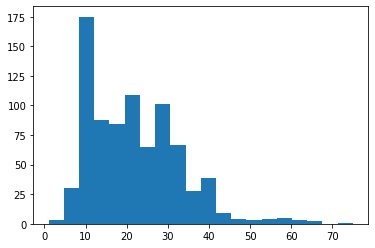

In [249]:
print(textStatistics(pharma_medication, "medication"))
print([feature for feature in pharma_medication["medication"] if len(feature)<5])
print([feature for feature in pharma_medication["medication"] if len(feature)>70])


<u>Fluids</u> (*see above for vasopressors*)

In [ ]:
input_label[input_label.label.str.contains("Sodium")]

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

### **<u>inputevents (MIMIC_IV ICU)</u>** (_icu_ module)
Because the table is in the _icu_ model, it relates to ICU data only and we perform our analysis on the whole table.

_inputevents_: **10 953 713** rows
Contains **76 510** distinct (`subject_id`, `hadm_id`)

1) <u>integrity</u>
- There are **8 732** (`subject_id`, `hadm_id`) that don't have any input events associated data
- There are no errors in the (`subject_id`, `hadm_id`) referenced in _inputevents_.
- 10 rows with `starttime` > `endtime`

2) <u>counts</u> 
none of `subject_id`, `hadm_id` or `stay_id` is ever null 
- number of inputevent rows per (`subject_id`, `hadm_id`)
- (_from result of previous query_) average number of input events rows per (`subject_id`, `hadm_id`) **143.17**, ranging from **1** to **13 107**

3) <u>null values</u>
- `starttime`, `endtime`, `itemid`, `amount`, `amountuom` are never null ; `statusdescription`, `originalamount`, `originalrate` either
- **4897231** of the rows have null `rate`, **4897231** have null `rateuom` (there are always null on the same rows)

</div>

<span style="color:silver">\# first we select all subject_id-hadm_id pairs in inputsevents</span>

    SELECT subject_id, hadm_id, COUNT(*) 
    FROM `physionet-data.mimiciv_3_1_icu.inputevents`
    GROUP BY subject_id, hadm_id

<span style="color:silver">\# then with result from previous query. We look at the patient admission with no inputevents data</span>

    SELECT COUNT(*) 
    FROM `iame-int.ICU.patientICUstays` P
    LEFT JOIN `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon9c8cd8b717c152f721410b03f0ea1f677b7e35b641629b0472f484bbdde98d07` I
    ON P.subject_id=I.subject_id AND P.hadm_id=I.hadm_id
    WHERE I.subject_id IS NULL

<span style="color:silver">\# coherence check query on time</span>

    SELECT * FROM `physionet-data.mimiciv_3_1_icu.inputevents`
    WHERE starttime > endtime

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

`itemid` in the _inputevents_ table

We first compute the frequency of each type of input (`itemid`) in the overall table, and we join the result on _d_items_ to obtain the label (we could have further obtained more information such as unit and normal values for each item). There are **327** distinct `itemid` in the _inputevents_ table (note that the _d_items_ lists **4095** different items).

**First problem:** some input `label` appear several times in the _d_items_ but with different `itemid`. Among the items that are referenced in _inputevents_, there are two such labels ("Dexmedetomidine (Precedex)" and "Angiotensin II (Giapreza)") that have two `itemid`'s. 
</div>

<span style="color:silver">\# list of distinct itemid in the inputevents table and their frequency</span>

    SELECT itemid, COUNT(*) / (SELECT COUNT(*) FROM `physionet-data.mimiciv_3_1_icu.inputevents`)
    FROM `physionet-data.mimiciv_3_1_icu.inputevents`
    GROUP BY itemid ;

<span style="color:silver">\# with result from previous table, we extract the labels corresponding to the different itemid in inputevents</span>

    SELECT D.label, L.* FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon1f56d22d193c62a4ae3be41c3994097a609bc8d968373952a3e2448e9e19193a` L
    JOIN `physionet-data.mimiciv_3_1_icu.d_items` D
    ON L.itemid=D.itemid

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

Since there is a problem with the referenced `itemid`'s in _inputevents_, we look at the entire table. `itemid` is indeed unique to each row (**primary key**). However, **123** `label` appear several times but with different `itemid` (**7** appear 3 times, **116** appear twice). Checking manually the corresponding rows, we see that 
- "Low Speed Limit (VAD)" appears with `itemid` $229836$ and $229895$, but with different `unitname` and `param_type` (text vs numeric)
- **58** appear twice but with `param_type` "checkbox" and "text" 

### **TO DO: CHECK REDUNDANCY BETWEEN THOSE TWO OPTIONS**

So we extract and recompute the frequency of the labels (and not the `itemid`) in the _inputevents_ table.

Hence there are actually **325** distinct `label`'s for events in _inputevents_ (compared to **325** distinct `itemid`'s)

**`df_inputevents` is the csv file of the distinct labels in _inputevents_**

- 0 capitalization problem
- 0 extra space problem
- 2 typos in the medication names (`label` from _d_items_ joined on _inputevents_) where there is an additional period at the end of the label name ("Beneprotein." and "Epinephrine.")

</div>

In [71]:
df_inputevents = pd.read_csv("../Data/MIMIC-IV/inputevents_distinctItemid.csv")
input_label = pd.DataFrame(df_inputevents["label"])
print("The number of distinct labels is", len(df_inputevents))
input_label.head()

The number of distinct labels is 325


,label
0,Pulmocare (1/4)
1,Lipids 10%
2,Boost Glucose Control (1/4)
3,Ensure (3/4)
4,Vanilla Lactose Free Scandi Shake (mixed)


In [119]:
countExtraSpaces(input_label, "label")
countCapitalization(input_label, "label")
detectTypos(input_label, "label")

,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,pulmocare (1/4),pulmocare (1/2),93,92,92,0.182574
1,boost glucose control (1/4),boost glucose control (1/2),96,96,96,0.090536
2,boost glucose control (1/4),boost glucose control (3/4),96,96,96,0.090536
3,phenylephrine (50/250),phenylephrine (200/250),93,93,93,0.136148
4,acd-a citrate (1000ml),acd-a citrate (500ml),93,92,92,0.141500
5,albumin 25%,albumin 5%,95,95,95,0.154347
6,epinephrine,epinephrine.,96,100,100,0.103148
7,fibersource hn (3/4),fibersource hn (1/4),95,94,94,0.138675
8,replete with fiber (1/4),replete with fiber (2/3),92,91,91,0.144338
9,replete with fiber (1/4),replete with fiber (3/4),96,95,95,0.102062


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

<u>Units in _inputevents_</u>

`amountuom` uses **22** distinct units
- 0 problem with capitalization
- 0 problem with extra spaces
- equivalent units are used: $mm^3$ and ${\mu}L$, $cm^3$ and $mL$

No problem in `rateuom`

Observe that there is a problem (probably typos) in the weight distribution, as there are **1 977** rows were `patientweight`>400 (weight is indicated in kilograms), including **332** values >1000, ranging up to **20 000.0** and **14 109.0**. Weight is quite continuous, with a non-negligeable number of patients, until 146.0 kg when it starts being a bit more scattered. **49 116** patients have `patientweight` > 200, **4 730** above 300. There are also **21 576** patient with weight < 30, including **13 971** with `patientweight` = 1.0

 A <mark>validation query</mark> confirms that all `caregiver_id` relate to a row in the _caregiver_ table
 </div>

<span style="color:silver">\# validation query on caregiver_id</span>

<span style="color:silver">\# result is null </span>

    SELECT I.caregiver_id 
    FROM `physionet-data.mimiciv_3_1_icu.inputevents` I
    LEFT JOIN `physionet-data.mimiciv_3_1_icu.caregiver` C
    ON I.caregiver_id = C.caregiver_id
    WHERE C.caregiver_id IS NULL 

In [73]:
# because we are not able to export the whole document, this is a sample of 977 112 of the patientweights in inputevents
df_patientweight = pd.read_csv("../Data/MIMIC-IV/inputevents_patientweight_extrait.csv")
outliers(df_patientweight, "patientweight")

[1.0,
 190.0,
 159.0,
 181.0,
 164.0,
 176.0,
 161.0,
 161.3,
 200.0,
 190.0,
 159.0,
 167.0,
 160.5,
 275.0,
 165.0,
 204.0,
 195.8,
 188.0,
 183.0,
 211.0,
 180.0,
 167.0,
 188.0,
 230.0,
 156.0,
 178.0,
 156.0,
 230.0,
 174.4,
 177.3,
 296.8,
 181.8,
 164.9,
 158.7,
 160.6,
 177.3,
 309.0,
 174.0,
 182.0,
 163.0,
 250.0,
 186.8,
 245.0,
 157.0,
 156.0,
 177.0,
 200.0,
 158.9,
 176.0,
 196.0,
 160.0,
 209.0,
 162.6,
 190.0,
 181.0,
 249.1,
 163.3,
 207.3,
 186.0,
 162.0,
 199.5,
 201.9,
 182.1,
 181.3,
 630.0,
 1.0,
 226.0,
 226.0,
 199.0,
 161.9,
 158.0,
 165.2,
 160.3,
 180.5,
 159.1,
 219.3,
 195.8,
 155.0,
 172.0,
 162.3,
 200.6,
 190.0,
 219.1,
 1.0,
 177.3,
 164.0,
 158.3,
 309.0,
 191.0,
 175.0,
 164.0,
 212.3,
 200.0,
 232.0,
 178.9,
 213.0,
 171.3,
 183.6,
 296.8,
 155.0,
 204.0,
 219.1,
 176.0,
 182.3,
 195.8,
 190.0,
 164.0,
 1.0,
 181.0,
 178.0,
 159.8,
 163.6,
 225.0,
 172.0,
 202.0,
 168.0,
 166.0,
 272.0,
 159.1,
 242.6,
 174.0,
 213.0,
 166.8,
 200.0,
 168.2,
 163.6,


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

### **<u>Procedures:</u>** the _procedureevents_ table

`itemid` indicates the references of the procedure performed, and we can obtain the "human readable" name of the procedure by performing a join on _d_items_.
- There are **159** different procedures (`itemid`) in _procedureevents_ 

`ordercategoryname` indicates the type of procedure ("Ventilation", "Procedures", "Invasive Lines" etc)
- There are **14** distinct `ordercategoryname`


### TO DO: check the consistency of `itemid` between _procedureevents_ and *d_items*
</div>

<span style="color:silver">\# the distinct procedures in procedureevents and their frequency</span>

    SELECT I.label, COUNT(*) AS count_procedure, 
      100* (COUNT(*) / (SELECT COUNT(*) FROM `physionet-data.mimiciv_3_1_icu.procedureevents`))
    FROM `physionet-data.mimiciv_3_1_icu.procedureevents` P
    JOIN `physionet-data.mimiciv_3_1_icu.d_items` I
    ON P.itemid=I.itemid 
    GROUP BY I.label
    ORDER BY count_procedure DESC ;

<span style="color:silver">\# different order category name and their frequency in procedureevents</span>

    SELECT ordercategoryname, COUNT(*) AS count_categoryname,
      100*(COUNT(*)/(SELECT COUNT(*) FROM `physionet-data.mimiciv_3_1_icu.procedureevents`)) AS percentage_categoryname
    FROM `physionet-data.mimiciv_3_1_icu.procedureevents` 
    GROUP BY ordercategoryname
    ORDER BY count_categoryname DESC

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

# Sepsis focus

Although we did some analysis for sepsis before, we do it now again with more detail.

We have studied before the diagnosis of sepsis, and looked a bit into medication administration, which we will start again going more into details. 

We already saved as a BigQuery table _sepsisDiagnose_ the list of `icd_code`, `icd_version` and `long_title` corresponding to the diagnosis of sepsis. Using this, we extract the list of admissions `hadm_id` that have, in one of the associated ICU stays, a sepsis diagnosis. We save the result as the BigTable _sepsisAdmissions_ (which, as computed before, indeed has **14 040** rows).
</div>

<span style="color:silver">\# the admissions that have a sepsis diagnosis</span>

    SELECT DISTINCT P.hadm_id, P.subject_id
    FROM iame-int.ICU.patientICUstays P
    JOIN physionet-data.mimiciv_3_1_hosp.diagnoses_icd D
    ON D.hadm_id = P.hadm_id # join on the ICU patients
    JOIN iame-int.ICU.sepsisDiagnoses S
    ON D.icd_code = S.icd_code AND D.icd_version = S.icd_version # join on all the sepsis diagnosis

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

Reminder:
- _emar_ is the table of the records of administration of a given medicine to a patient 
- _emar_detail_ is the table that contains information for each medicine administration made in the EMAR table
- _prescriptions_ is the table with the prescribed medications
- _pharmacy_ contains detailed information regarding filled medications which were prescribed to the patient

We are interested, in the case of sepsis specific medication, in the availability of information about:
- which medications were given (vasopressors and antiobiotics in particular) 
- molecule
- delay between prescriptions and administration 
- duration and dosage

To proceed, we look at all rows that correspond to an admission that has a sepsis diagnosis. To this purpore, we join _pharmacy_, _prescriptions_ and _emar_ with _sepsisAdmissions_ on `hadm_id`. We obtain the corresponding data for _emar_detail_ by a join on `emar_id` with the result of the _emar_ table. The number of rows for each query is:
- _emar_ 
- _prescriptions_ **2 203 538**
- _pharmacy_ 

**There is a clear distinction in MIMIC-IV between the drugs that are <u>prescribed</u>, with their dosage and frequency, and the drugs that are actually given the patients.**

**_prescriptions_**

We study all tables, starting with the data extracted from _prescriptions_, based on the `hadm_id` that have at some point a sepsis diagnosis. In the following, we will refer to this data as _sepsisPrescriptions_. 

- Note that _prescriptions_ does not use the ICD-9 and ICD-10 codes. It only provides a free-text descriptions( which leads to typos) through the attribute `drug` (never null), and the **Generic Sequence Number (GSN)** and the **National Drug Code (NDC)** are indicated in prescriptions. However, `gsn` is null for **388 245** or **17.61%** of the rows (`ndc` is null for **2 445** or **0.11%** of the rows).

Details about the medication administration (<u>specific to _sepsisPrescriptions_</u>) are the following:

| Attribute | Description | Type | Null values | Distinct values (null excluded) | Capitalization | Extra spaces | Typos or inconsistencies | Note | 
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| `starttime` | prescribed start for medication | Timestamp | **1 264** (**0.06%**) | - | - | - | - | - |
| `stoptime` | prescribed stop for medication | Timestamp | **3 498** (**0.16%**) | - | - | - | - | **99 436** rows (4.51%) where `stoptime` < `starttime` |
| `route` | route of administration | String | **1 706** (**0.08%**) | **80** | - | - | 1 | Difference in abbreviation or full string |
| `dose_val_rx` | prescribed dose intended to be administered over the given time period | numerical | **1 752** (**0.08%**) | 1 558 | - | - | - | - |
| `dose_unit_rx` | unit of measurement of the prescribed dose | text | **1 752** (**0.08%**) | 95 | 6 | 0 | 1 | - |
| `form_val_disp` | amount of the medication which is contained in a single formulary dose | numerical | **1 752** (**0.08%**) | - | - | - | - | `dose_unit_rx` and `dose_val_rx` and `form_val_disp` and `form_unit_disp` are always null in the exact same rows |
| `form_unit_disp` | unit of measurement used for the formulary dosage | text | **1 752** (**0.08%**) | 74 | 3 | 0 | 0 | we did not count as null the empty space, which is also a value in the column |
| `doses_per_24_hrs` | number of doses per 24 hours for which the medication is to be given | numerical | **908 694** (**41.24%**) | - | - | - | - | **71 331** (3.24%) rows where it is 0.0 |

_prescriptions_ also indicates the container in which the formulary dose is delivered (`form_rx`)

</div>

<span style="color:silver">\# extracting the sepsis data from prescriptions</span>

    SELECT * 
    FROM `physionet-data.mimiciv_3_1_hosp.prescriptions` P
    JOIN iame-int.ICU.sepsisAdmissions S
    ON P.hadm_id = S.hadm_id

<span style="color:silver">\# we use the result of the above query for the following analysis</span>

<span style="color:silver">\# inconsistency in time</span>

    SELECT *
    FROM soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anonb05f5e8ba3f4764edf378fe31a0a14a612071ffdf9d7d8fdf1dccc231b5eebd9
    WHERE stoptime IS NOT NULL and starttime IS NOT NULL AND stoptime < starttime

    

In [13]:
# the distinct units in sepsis prescriptions, dose_unit_rx
sepsis_prescriptions_doseunit = pd.read_csv("../Data/MIMIC-IV/sepsisPrescriptionsUnits.csv")
countCapitalization(sepsis_prescriptions_doseunit, "dose_unit_rx")
countExtraSpaces(sepsis_prescriptions_doseunit, "dose_unit_rx")
detectTypos(sepsis_prescriptions_doseunit, "dose_unit_rx") 

# distint units in form_unit_disp
sepsis_precriptions_formunit = pd.read_csv("../Data/MIMIC-IV/sepsisPrescriptionsFormunit.csv")
countCapitalization(sepsis_precriptions_formunit, "form_unit_disp")
countExtraSpaces(sepsis_precriptions_formunit, "form_unit_disp")
detectTypos(sepsis_precriptions_formunit, "form_unit_disp")

,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,syrp,spry,50,50,50,0.0
1,gm,mg,50,50,50,0.0


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**_emar_**

From now on we refer to the data extracted from _emar_ associated with sepsis patients form _sepsisAdmissions_ as _sepsisEmar_. It has **5 691 459** rows. 

Only **9 378** `hadm_id` (**66.79%**) that have a sepsis diagnosis have emar data.

| Attribute | Description | Type | Null values | Distinct values (null excluded) | Capitalization | Extra spaces | Typos or inconsistencies | Note | 
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| `charttime` | time at which the medication was administered | timestamp | 0 (never null) | - | - | - | - | - |
</div>

<span style="color:silver">\# extracting the emar data for sepsis patients</span>

    SELECT * 
    FROM `physionet-data.mimiciv_3_1_hosp.emar` E
    JOIN iame-int.ICU.sepsisAdmissions S
    ON E.hadm_id = S.hadm_id

<span style="color:silver">\# with result from above query</span>

<span style="color:silver">\# distinct sepsis patients for which emar data is available </span>

    SELECT COUNT(DISTINCT hadm_id)
    FROM soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon3c9090276fd2fdfaca4289a672b9176ac40948001c5019ef350034720be25249


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**_emar_detail_**

We extract the relevant _emar_detail_ data by a join on the `emar_id`'s with _spesisEmar_. We obtain **11 241 721** rows, including **** or **** distinct `hadm_id` related to sepsis. We refer to this data as _sepsisEmar_detail_.

From this table we analyse the important information about dosage etc. 

| Attribute | Description | Type | Null values | Distinct values (null excluded) | Capitalization | Extra spaces | Typos or inconsistencies | Note | 
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| `administration_type` | type of administration | text | **5 550 446** (**49.37%**) | 23 | 0 | 0 | 0 | - | 
| `dose_due` | | numerical ( and "___") | **5 936 214** (**52.81%**) | - | - | - | - | **7 812** rows where `dose_due`= "___" |
| `dose_due_unit` | | text | **5 585 994** (**49.69%**) | 204 | see previous analysis | see previous analysis | see previous analysis | 10 455 rows where `dose_due` is not null but `dose_due` is null |
| `dose_given` | | numerical and "___" | **6 477 351** (**57.62%**) | - | - | - | - | **1 370** rows where `dose_given` = "___" |
| `dose_given_unit` | | text | **6 354 388** (**56.53%**) | see previous analysis | see previous analysis | see previous analysis | - |
| `infusion_rate` | | numerical | **10 832 088** (**96.36%**) | - | - | - | - | **1** row where equal to "___" |


The table includes a lot of other information, for which we have counted null values and inconssitencies for units in particular previously.

</div>

<span style="color:silver">\# obtaining with result from above query the relevant emar_detail data</span>

    SELECT ED.*
    FROM soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon3c9090276fd2fdfaca4289a672b9176ac40948001c5019ef350034720be25249 E
    JOIN `physionet-data.mimiciv_3_1_hosp.emar_detail` ED
    ON E.emar_id = ED.emar_id

<span style="color:silver">\# following analysis with result from above query</span>

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

Then, the _pharmacy_ table also includes the information about the <u>filled</u> prescriptions.

About the specific medications: there are **1 906** distinct medications (including null) that were administered to patients with sepsis. 

- We extract the data we are interested in related to <mark>vasopressors</mark> using the `medication` name in _sepsisEmar_ we already extracted in our previous work. 
    - there are **30 175** rows (**0.53%**) corresponding to administration of vasopressor
    - when using vasopressors, the most often used is "Vasopressin" (**99.13%** of the time)
    - the second most used is "Lidocaine 1%/Epinephrine 1:100,0" but only **0.53%**
    - **2 836** `hadm_id` or **20.20%** of sepsis diagnosed admissions have vasopressors administration in emar 
    
<mark>fluids</mark> in _sepsisEmar_
- **2 502** or **17.82%** of sepsis associated `hadm_id` or **26.68%** of `hadm_id` that have sepsis AND emar data, have fluid administration
    

- Now the data related to <mark>fluids</mark> in _sepsisPharmacy_ 
    - there are **18 443** rows in _sepsisPharmacy_ that have `medication` included in the `fluids` list (that has **149** values)
    - **** or **%** of `hadm_id` with sepsis have fluid administration in 
    - there are **** distinct `medication` that appear in the sepsis related _pharmacy_ data
    - most used fluid is 
    
</div>

<span style="color:silver">\# data related to vasopressors in the emar table of sepsis admissions with sepsis emar data</span>

    SELECT *
    FROM soy-surge-447815-u0._137b5fc472330f4235ee24cade8c7b589730ce30.anon3c9090276fd2fdfaca4289a672b9176ac40948001c5019ef350034720be25249
    WHERE medication IN ('vasopressin',
     'epinephrine 1:1000',
     'norepinephrine',
     'epinephrine (epipen)',
     'lidocaine 0.5%/epinephrine',
     'lidocaine-epinephrine',
     'lidocaine 1%/epinephrine 1:100,000',
     'epinephrine',
     'lidocaine 1%/epinephrine 1:200,000',
     'epinephrine 1 mg/1 ml',
     'bupivacaine 0.50%-epinephrine',
     'lidocaine 1%/epinephrine 1:100000',
     'racepinephrine',
     'lidocaine 1%/epinephrine 1:200000',
     'lidocaine-epinephrine (pf)',
     'dobutamine',
     'Vasopressin',
     'Lidocaine 1%/Epinephrine 1:100,000',
     'Epinephrine 1:1000',
     'Lidocaine 0.5%/Epinephrine',
     'Lidocaine 1%/Epinephrine 1:200,000',
     'Bupivacaine 0.50%-Epinephrine',
     'Lidocaine 1%/Epinephrine 1:100000',
     'Lidocaine 1%/Epinephrine 1:200000')

In [85]:
fluids = ['IV Lactated ringers w/ mvi',
 'ammonium lactate',
 'albumin 5',
 'albumin 5%',
 'albumin',
 'Albumin 5% (25g / 500mL)',
 'Albumin 5% (12.5g / 250mL)',
 'Albumin 25% (12.5g / 50mL)',
 'Albumin 5%',
 'Albumin 25%',
 'Albumin 5% ',
 'Albumin ',
 'Albumin 5',
 'Albumin 25% (25g /100mL)',
 'Albumin',
 'Albumin 5% )',
 'Albumin 25% ',
 'Albumin 5% 12.5g/250mL 250mL BAG',
 'Albumin 5% (',
 'sodium chloride 0.9%',
 'Sodium chloride 0.9%',
 'sodium chloride 0.9 % (flush)']

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

Finally, the <mark>antibiotics</mark>. We use an exhaustive list of antibiotics names, all decapitalized, with their full names, and we search for them in the normalized medications (so this does not detect typos or extra spaces for examples, nor medical abbreviations).

- `drug` in _sepsisPrescriptions_
    - **2 981** distinct values 
    - **285** differences in capitalization
    - **62** differences in spaces
    - **56** typos, punctuation differences, word inversions etc
    
- `medication` in _sepsisEmar_
    - **1 905** distinct values 
    - **192** differences in capitalization
    - **24** differences in spaces
    
- `medication` in _sepsisPharmacy_ 
    - **2 904** distinct values
    - **316** differences in capitalization
    - **71** differences in spaces
    
We don't detect much values in the three different medication/drug features. Using the previously obtaine`df_inputevents`, we perform the same search (not only limited to sepsis patients) and it is empty.
</div>

<span style="color:silver">\# medications from prescriptions for sepsis diagnosed patients</span>

    SELECT DISTINCT drug 
    FROM physionet-data.mimiciv_3_1_hosp.prescriptions P
    JOIN iame-int.ICU.sepsisAdmissions S
    ON P.hadm_id = S.hadm_id

<span style="color:silver">\# medications from emar for sepsis diagnosed patients</span>

    SELECT DISTINCT medication 
    FROM physionet-data.mimiciv_3_1_hosp.emar E
    JOIN iame-int.ICU.sepsisAdmissions S
    ON E.hadm_id = S.hadm_id

<span style="color:silver">\# medications from pharmacy for sepsis diagnosed patients</span>

    SELECT DISTINCT medication 
    FROM physionet-data.mimiciv_3_1_hosp.pharmacy P
    JOIN iame-int.ICU.sepsisAdmissions S
    ON P.hadm_id = S.hadm_id

In [47]:
antibio = pd.read_csv("../Data/antiobio_list.csv", header = None, names=["antibio"])
antibio = normalizeDataframe(antibio, "antibio") # we de-capitalize all values

# now we load the medication names in pharmacy and in emar and we attempt at detecting the antibiotics
sepsis_prescriptions_medication = pd.read_csv("../Data/MIMIC-IV/sepsisPrescriptionsMedication.csv")
sepsis_emar_medication = pd.read_csv("../Data/MIMIC-IV/sepsisEmarMedication.csv")
sepsis_pharmacy_medication = pd.read_csv("../Data/MIMIC-IV/sepsisPharmacyMedication.csv")

In [87]:
# for prescriptions

sepsis_prescriptions_antibio = []

# here we want to keep the capitalized versions of the medication in the actual table, but we pertorm detection on decapitalize
# thus we create a dataframe with the decapitalize version associated to each value
decap_sepsis_prescriptions_medication = sepsis_prescriptions_medication.copy()
decap_sepsis_prescriptions_medication["decap_drug"] = decap_sepsis_prescriptions_medication['drug'].str.lower()

for ia, a in antibio.iterrows() :
    a_data = decap_sepsis_prescriptions_medication[decap_sepsis_prescriptions_medication.decap_drug.str.contains(a["antibio"])]
    sepsis_prescriptions_antibio += a_data.decap_drug.tolist()
print("Number of detected antibiotics in sepsis_prescriptions_medication is", len(sepsis_prescriptions_antibio))
    
# for emar

sepsis_emar_antibio = []

# here we want to keep the capitalized versions of the medication in the actual table, but we pertorm detection on decapitalize
# thus we create a dataframe with the decapitalize version associated to each value
decap_sepsis_emar_medication = sepsis_emar_medication.copy()
decap_sepsis_emar_medication["decap_medication"] = decap_sepsis_emar_medication['medication'].str.lower()

for ia, a in antibio.iterrows() :
    a_data = decap_sepsis_emar_medication[decap_sepsis_emar_medication.decap_medication.str.contains(a["antibio"])]
    sepsis_emar_antibio += a_data.decap_medication.tolist()
print("Number of detected antibiotics in sepsis_emar_medication is", len(sepsis_emar_antibio))

# for pharmacy

sepsis_pharmacy_antibio = []

# here we want to keep the capitalized versions of the medication in the actual table, but we pertorm detection on decapitalize
# thus we create a dataframe with the decapitalize version associated to each value
decap_sepsis_pharmacy_medication = sepsis_pharmacy_medication.copy()
decap_sepsis_pharmacy_medication["decap_medication"] = decap_sepsis_pharmacy_medication['medication'].str.lower()

for ia, a in antibio.iterrows() :
    a_data = decap_sepsis_pharmacy_medication[decap_sepsis_pharmacy_medication.decap_medication.str.contains(a["antibio"])]
    sepsis_pharmacy_antibio += a_data.decap_medication.tolist()
print("Number of detected antibiotics in sepsis_pharmacy_medication is", len(sepsis_pharmacy_antibio))

/var/folders/9h/s0d6t4xd4vn84wctw4tp91t00000gn/T/ipykernel_16373/4015721013.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  a_data = decap_sepsis_prescriptions_medication[decap_sepsis_prescriptions_medication.decap_drug.str.contains(a["antibio"])]
/var/folders/9h/s0d6t4xd4vn84wctw4tp91t00000gn/T/ipykernel_16373/4015721013.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  a_data = decap_sepsis_emar_medication[decap_sepsis_emar_medication.decap_medication.str.contains(a["antibio"])]


Number of detected antibiotics in sepsis_prescriptions_medication is 177
Number of detected antibiotics in sepsis_emar_medication is 145
Number of detected antibiotics in sepsis_pharmacy_medication is 186


/var/folders/9h/s0d6t4xd4vn84wctw4tp91t00000gn/T/ipykernel_16373/4015721013.py:39: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  a_data = decap_sepsis_pharmacy_medication[decap_sepsis_pharmacy_medication.decap_medication.str.contains(a["antibio"])]


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**We look at medication administration in eMAR** (that is, what was actually administered and not what was only prescribed). 
- eMAR data for sepsis diagnosed `hadm_id` is **5 691 459** rows
- for **9 378** distinct `hadm_id` (**33.21%** of `hadm_id` don't have emar data)
- among these administrations, there are **1 905** distinct `drug` name


- <mark>vasopressors</mark>
    - **4** distinct vasopressors
    - **109 385** rows or **1.92%** of the sepsis related emar data
    - **5 659** distinct `hadm_id` with vasopressor administration (**40.31%** of `hadm_id` with sepsis diagnosis)
    
- <mark>fluids</mark>
    - **15** distinct fluids
    - **18 506** rows or **0.33%** of sepsis related emar data
    - **2 509** distinct `hadm_id` with fluids administration in emar (**17.87%** of `hadm_id` with sepsis diagnosis)
    
- <mark>antibiotics</mark>
    - **145** distinct antibiotics
    - **352 084** rows or **6.19%** of sepsis related emar data
    - **9 038** distinct `hadm_id` with antibiotic administration in emar so **almost all `hadm_id` that have emar data** (**64.37%** of `hadm_id` with sepsis diagnosis)
    
</div>

In [123]:
emar_antibio

['Penicillin G K Graded Challenge',
 'Penicillin G Potassium',
 'Penicillin G Benzathine',
 'Oxacillin',
 'DiCLOXacillin',
 'Amikacin',
 'AMIKACIN - DOSING BY PHARMACY',
 'Amikacin - Dosing by pharmacy',
 'Tobramycin 0.3% Ophth Soln',
 'Tobramycin-Dexamethasone Ophth Oint',
 'Tobramycin - Dosing by pharmacy',
 'Tobramycin Fortified Ophth. Soln.',
 'Tobramycin 0.3% Ophth Ointment',
 'Tobramycin Inhalation Soln',
 'Tobramycin-Dexamethasone Ophth Susp',
 'Tobramycin',
 'Tobramycin 2.5 mg/mL in Sodium Citrate 4%',
 'Amoxicillin-Clavulanic Acid',
 'Amoxicillin',
 'AMOXicillin Oral Susp.',
 'Amoxicillin-Clavulanate Susp.',
 'ertapenem',
 'Ertapenem Sodium',
 'Meropenem',
 'Meropenem Desensitization',
 'Meropenem Graded Challenge',
 'CeFAZolin Desensitization',
 'CeFAZolin Graded Challenge',
 'CefazoLIN',
 'CeFAZolin-Heparin Lock (For HD/Pheresis Catheter)',
 'CeFAZolin',
 'cefOXitin',
 'Penicillin V Potassium',
 'Piperacillin-Tazobactam',
 'Piperacillin-Tazo Graded Challenge',
 'Bacitracin O

In [92]:
vasopressors = ["vasopressin", "ephinephrine", "adrenaline", "dobutamine", "norepinephrine", "noradrenaline"]
fluids = ["lactate", "ringer", "albumin"]
antibio = pd.read_csv("../Data/antiobio_list.csv", header = None, names=["antibio"])
antibio = normalizeDataframe(antibio, "antibio") # we de-capitalize all values

In [94]:
decap_sepsis_emar_medication = sepsis_emar_medication.copy()
decap_sepsis_emar_medication["decap_medication"] = decap_sepsis_emar_medication['medication'].str.lower()
decap_sepsis_emar_medication

,medication,decap_medication
0,CefePIME,cefepime
1,Vancomycin,vancomycin
2,NORepinephrine,norepinephrine
3,Fentanyl Citrate,fentanyl citrate
4,Sodium CITRATE 4%,sodium citrate 4%
...,...,...
1900,lidocaine-epinephrine,lidocaine-epinephrine
1901,L-Carnitine study drug bolus,l-carnitine study drug bolus
1902,CoEnzyme Q10 (300 mg) or Placebo,coenzyme q10 (300 mg) or placebo
1903,Vitamin d3 / placebo,vitamin d3 / placebo


In [107]:
emar_vasopressors = []
for v in vasopressors :
    v_data = decap_sepsis_emar_medication[decap_sepsis_emar_medication.decap_medication.str.contains(v)]
    emar_vasopressors += v_data.medication.tolist()
print("the number of vasopressors medication we identify in emar is", len(emar_vasopressors))

emar_fluids = []
for f in fluids :
    f_data = decap_sepsis_emar_medication[decap_sepsis_emar_medication.decap_medication.str.contains(f)]
    emar_fluids += f_data.medication.tolist()
sod = decap_sepsis_emar_medication[decap_sepsis_emar_medication.decap_medication.str.contains("sodium")&decap_sepsis_emar_medication.medication.str.contains("chloride")]
emar_fluids += sod.medication.tolist()
print("the number of fluid medication we identify in emar is", len(emar_fluids))

emar_antibio = []
for i_a, a in antibio.iterrows() :
    print(a["antibio"])
    a_data = decap_sepsis_emar_medication[decap_sepsis_emar_medication.decap_medication.str.contains(a["antibio"])]
    emar_antibio += a_data.medication.tolist()
emar_antibio
print("the number of antibio drugnames we identify in emar is", len(emar_antibio))

the number of vasopressors medication we identify in emar is 4
the number of fluid medication we identify in emar is 15
penicillin g
streptomycin
cefadroxil
oxacillin
amikacin
tobramycin
paromomycin
amoxicillin
ertapenem
doripenem
imipenem/cilastatin
meropenem
kanamycin
cefazolin
cephradine
cephapirin
cephalothin
cefalexin
cefaclor
cefoxitin
cefotetan
penicillin v
piperacillin
netilmicin
temocillin
ticarcillin
amoxicillin/clavulanate
ampicillin/sulbactam
piperacillin/tazobactam
ticarcillin/clavulanate
meropenem/vaborbactam
imipenem/cilastatin/relebactam
ceftolozane/tazobactam
ceftazidime/avibactam
cefepime/enmetazobactam
cefepime/zidebactam
aztreonam/avibactam
bacitracin
colistin
polymyxin b
ciprofloxacin
enoxacin
gatifloxacin
gemifloxacin
levofloxacin
lomefloxacin
ethionamide
isoniazid
pyrazinamide
rifampicin (rifampin in us)
rifabutin
rifapentine
arsphenamine
chloramphenicol(bs)
fosfomycin
demeclocycline
moxifloxacin
nadifloxacin
nalidixic acid
norfloxacin
ofloxacin
mafenide
sulfacet

/var/folders/9h/s0d6t4xd4vn84wctw4tp91t00000gn/T/ipykernel_16373/2111059872.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  a_data = decap_sepsis_emar_medication[decap_sepsis_emar_medication.decap_medication.str.contains(a["antibio"])]


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**We look at medication administration in inputevents** (that is, what was actually administered and not what was only prescribed). 
- _inputevents_ for sepsis related `hadm_id` has **3 984 462** rows
- for **12 284** distinct `hadm_id`, that is, **87.49%** of sepsis related `hadm_id`
- among these administrations, there are **1 905** distinct `drug` name


- <mark>vasopressors</mark>
    - 3 distinct vasopressors
    - **313 972** rows or **7.88%** of the sepsis related inputevents data
    - **7 446** distinct `hadm_id` with vasopressor administration
    
- <mark>fluids</mark>
    - 2 distinct fluids
    - **22 658** rows or **0.57%** of sepsis related inputevents data
    - **2 830** distinct `hadm_id` with fluids administration in inputevents
    
- <mark>antibiotics</mark>
    - 32 distinct antibiotics
    - **207 032** rows or **5.20%** of sepsis related inputevents data
    - **11 327** distinct `hadm_id` with antibiotic administration in inputevents **so most of admissions with sepsis**
    
</div>

<span style="color:silver">\# distinct label for inputevents for sepsis related patients </span>

    SELECT DISTINCT label
    FROM iame-int.ICU.sepsisAdmissions S
    JOIN `physionet-data.mimiciv_3_1_icu.inputevents` I
    ON S.hadm_id = I.hadm_id
    JOIN `physionet-data.mimiciv_3_1_icu.d_items` D
    ON I.itemid = D.itemid

    SELECT COUNT(*)
    FROM iame-int.ICU.sepsisAdmissions S
    JOIN `physionet-data.mimiciv_3_1_icu.inputevents` I
    ON S.hadm_id = I.hadm_id
    JOIN `physionet-data.mimiciv_3_1_icu.d_items` D
    ON I.itemid = D.itemid
    WHERE label in ('Vasopressin', 'Dobutamine', 'Norepinephrine')

In [113]:
sepsis_input_items = pd.read_csv("../Data/MIMIC-IV/sepsisInputeventsMedication.csv")
decap_sepsis_input_items = sepsis_input_items.copy()
decap_sepsis_input_items["decap_label"] = sepsis_input_items["label"].str.lower()

In [117]:
input_vasopressors = []
for v in vasopressors :
    v_data = decap_sepsis_input_items[decap_sepsis_input_items.decap_label.str.contains(v)]
    input_vasopressors += v_data.label.tolist()
print("the number of vasopressors medication we identify in emar is", len(input_vasopressors))

input_fluids = []
for f in fluids :
    f_data = decap_sepsis_input_items[decap_sepsis_input_items.decap_label.str.contains(f)]
    input_fluids += f_data.label.tolist()
sod = decap_sepsis_input_items[decap_sepsis_input_items.decap_label.str.contains("sodium")&decap_sepsis_input_items.decap_label.str.contains("chloride")]
input_fluids += sod.label.tolist()
print("the number of fluid medication we identify in emar is", len(input_fluids))

input_antibio = []
for i_a, a in antibio.iterrows() :
    a_data = decap_sepsis_input_items[decap_sepsis_input_items.decap_label.str.contains(a["antibio"])]
    input_antibio += a_data.label.tolist()
print("the number of antibio drugnames we identify in medication is", len(input_antibio))

the number of vasopressors medication we identify in emar is 3
the number of fluid medication we identify in emar is 2
the number of antibio drugnames we identify in medication is 32


/var/folders/9h/s0d6t4xd4vn84wctw4tp91t00000gn/T/ipykernel_16373/1223877726.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  a_data = decap_sepsis_input_items[decap_sepsis_input_items.decap_label.str.contains(a["antibio"])]


In [121]:
input_antibio

['Penicillin G potassium',
 'Amikacin',
 'Tobramycin',
 'Ertapenem sodium (Invanz)',
 'Imipenem/Cilastatin',
 'Meropenem',
 'Cefazolin',
 'Piperacillin',
 'Piperacillin/Tazobactam (Zosyn)',
 'Ampicillin/Sulbactam (Unasyn)',
 'Piperacillin/Tazobactam (Zosyn)',
 'Colistin',
 'Ciprofloxacin',
 'Levofloxacin',
 'Isoniazid',
 'Pyrazinamide',
 'Moxifloxacin',
 'Levofloxacin',
 'Ciprofloxacin',
 'Doxycycline',
 'Metronidazole',
 'Vancomycin',
 'Clindamycin',
 'Daptomycin',
 'Azithromycin',
 'Erythromycin',
 'Aztreonam',
 'Linezolid',
 'Gentamicin',
 'Ampicillin',
 'Ampicillin/Sulbactam (Unasyn)',
 'Nafcillin']